## License 

Copyright 2021 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 2

#### Imports and inits

In [1]:
import datetime                                               # for timestamp 
import h2o                                                    # base h2o package for python
from h2o.estimators import *                                  # h2o models
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from h2o.estimators.deeplearning import H2ODeepLearningEstimator # h2o deep learning model
from interpret import show                                    # basic visualizations from interpret package
from interpret.data import ClassHistogram                     # histogram
from interpret.glassbox import *                              # interpret glassboxx models
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python
from rmltk import explain, evaluate, model                    # simple module for training, explaining, and eval
import operator                                               # to sort dictionaries
from imblearn.over_sampling import RandomOverSampler          #Handle class imbalance
from imblearn.under_sampling import RandomUnderSampler        #Handle class imbalance
from imblearn.over_sampling import SMOTE                      #Handle class imbalance
from collections import Counter           
import shap                                                   # for visualizing Shapley values
# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/adelhassen/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1x/_t_zsqxx3_bdlb0k32ryftbm0000gn/T/tmpc8yyrh1e
  JVM stdout: /var/folders/1x/_t_zsqxx3_bdlb0k32ryftbm0000gn/T/tmpc8yyrh1e/h2o_adelhassen_started_from_python.out
  JVM stderr: /var/folders/1x/_t_zsqxx3_bdlb0k32ryftbm0000gn/T/tmpc8yyrh1e/h2o_adelhassen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_adelhassen_irnaz9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.333 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


#### Start global timer

In [2]:
global_tic = time.time()

#### Import data

In [3]:
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

#### Assign basic modeling roles

In [4]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Basic data exploration

#### Number of rows and columns of our training set

In [5]:
data[x_names].shape

(160338, 10)

#### Variable type of features

In [6]:
data[x_names].dtypes

term_360                          int64
conforming                        int64
debt_to_income_ratio_missing      int64
loan_amount_std                 float64
loan_to_value_ratio_std         float64
no_intro_rate_period_std        float64
intro_rate_period_std           float64
property_value_std              float64
income_std                      float64
debt_to_income_ratio_std        float64
dtype: object

#### Summary Statistics

In [7]:
data[x_names + [y_name]].describe()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
count,160338.000000,160338.000000,160338.000000,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,160338.000000
mean,0.960328,0.928027,0.000617,1.518971e-16,3.813309e-16,-1.243723e-15,-6.991775e-15,2.016754e-15,4.592073e-16,9.179888e-16,0.096702
std,0.195189,0.258444,0.024841,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.295552
min,0.000000,0.000000,0.000000,-1.261924e+00,-3.479243e+00,-4.091747e+00,-2.153042e-01,-1.090958e+00,-9.782313e-02,-2.527547e+00,0.000000
25%,1.000000,1.000000,0.000000,-5.583656e-01,-2.753968e-01,2.443944e-01,-2.153042e-01,-5.359324e-01,-3.337777e-02,-4.251308e-01,0.000000
50%,1.000000,1.000000,0.000000,-2.505590e-01,1.792226e-01,2.443944e-01,-2.153042e-01,-2.584194e-01,-2.332984e-02,1.233255e-01,0.000000
75%,1.000000,1.000000,0.000000,2.771095e-01,4.280875e-01,2.443944e-01,-2.153042e-01,1.732675e-01,-7.738221e-03,6.717818e-01,0.000000
max,1.000000,1.000000,1.000000,5.150493e+01,2.027553e+02,2.443944e-01,1.687735e+01,4.084434e+01,3.055430e+02,3.871110e+00,1.000000


#### Histograms

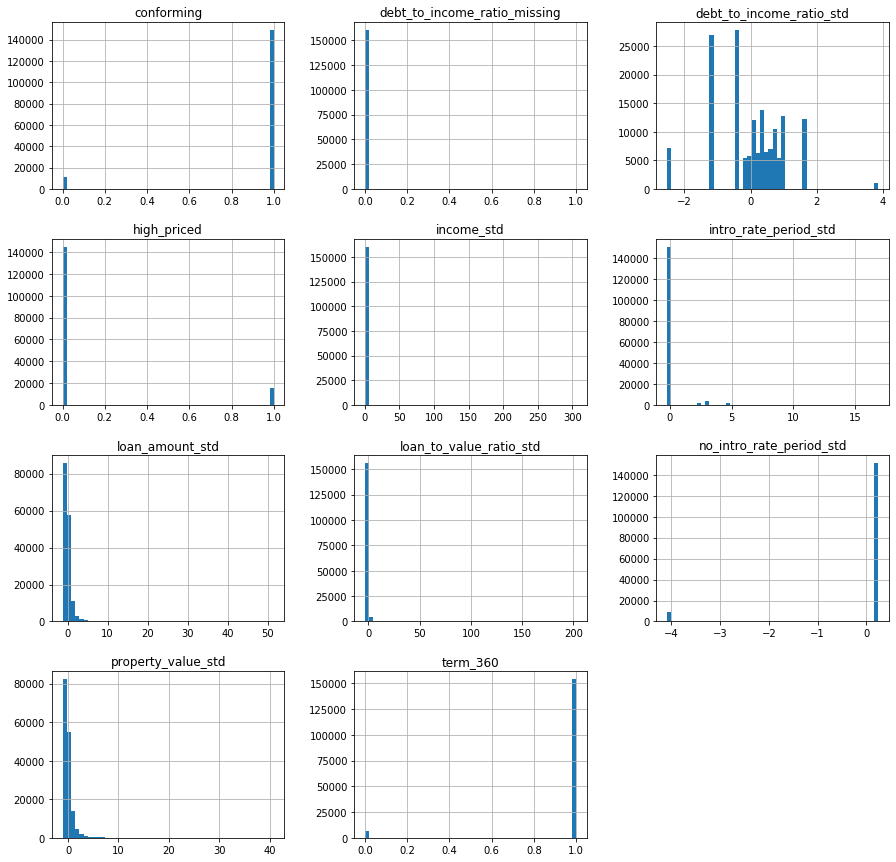

In [8]:
_ = data[x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Interactive Histograms

In [9]:
hist = ClassHistogram().explain_data(data[x_names], data[y_name], name = 'Train Data')
show(hist)

<!-- http://127.0.0.1:7001/116461537616/ -->

#### Correlations

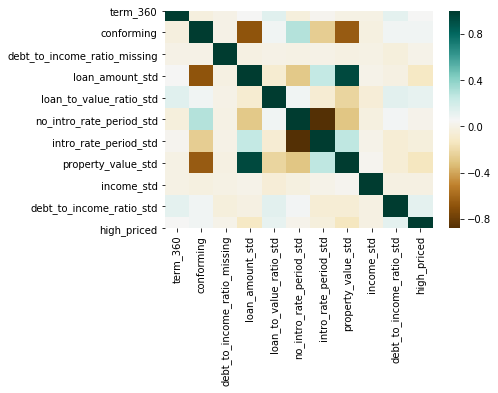

In [10]:
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                cmap = 'BrBG')

#### One way correlation with high_priced

In [11]:
data_for_pric_corrs = data[x_names + [y_name]]

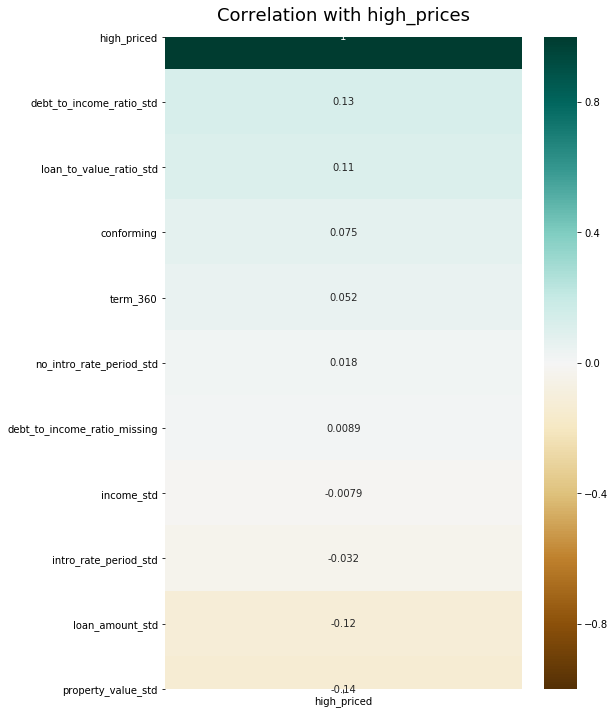

In [12]:
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(data_for_pric_corrs.corr()[['high_priced']].sort_values(by='high_priced', ascending=False), vmin = -1, vmax = 1, annot = True, cmap = 'BrBG')

heatmap.set_title('Correlation with high_prices', fontdict={'fontsize':18}, pad=16);

#### Another way to visualize correlation with a focus on direction

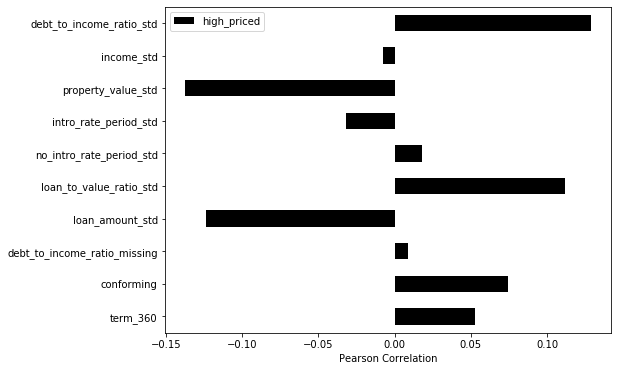

In [13]:
# display correlation to target as barchart
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1].plot(kind='barh', ax=ax_, colormap='gnuplot')
_ = ax_.set_xlabel('Pearson Correlation')

The previous three plots offer different ways of visualizing the correlation between our selected dependent variables and high_priced, our independent variable.The second and the third visuals are more easily interpretable because they focus solely on correlations with high_priced whereas the first visual calculates correlations between all variables.

The second plot relies on color to distinguish between positive and negative and the third plot utilizes direction and magnitude. Using either plot, we see that debt_to_income_ratio_std and loan_to_value_ratio_std have the largest positive correlations. This means that we expect the probability of high_priced to increase as the two aforementioned variables increase. property_value_std and loan_amount_std have the strongest negative correlations with high_priced. Although there appears to be a large disparity in our correlations, if we look at the axis, we notice that none of the correlations are greater that 0.15. This means they are all fairly weak correlations.

In [14]:
# Pearson correlation in a table
corr = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']
corr


,Pearson Correlation Coefficient
term_360,0.052448
conforming,0.074543
debt_to_income_ratio_missing,0.008857
loan_amount_std,-0.123545
loan_to_value_ratio_std,0.111540
no_intro_rate_period_std,0.018108
intro_rate_period_std,-0.031716
property_value_std,-0.137319
income_std,-0.007911
debt_to_income_ratio_std,0.128645


#### Accentuate the class imbalance

In [15]:
data.groupby('high_priced').size()

high_priced
0    144833
1     15505
dtype: int64

## Fit interpretable models

#### Split data into train and validation partitions 

In [16]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Elastic net

#### Define wrapper function for grid search

In [17]:
def glm_grid(x_names, y_name, htrain, hvalid, seed):

    """ Wrapper function for penalized GLM with alpha and lambda search.

    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.01, 0.25, 0.5, 0.99]  # always keep some L2

    # define search criteria
    # i.e., over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      seed=seed), # seed for grid search
        hyper_params=hyper_parameters)

    # execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed) # seed for training

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

#### Fit elastic net with grid search

In [18]:
# start local timer
glm_tic = time.time()

# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

# train with grid search
best_glm = glm_grid(x_names, y_name, htrain, hvalid, SEED)

# end local timer
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % (glm_toc))

Elastic net GLM training completed in 21.03 s.


In [19]:
# train penalized GLM w/ alpha and lambda grid search
GLM_SELECTION_THRESHOLD = 0.001   # threshold above which a GLM coefficient is considered "selected"

best_glm = model.glm_grid(x_names, y_name, h2o.H2OFrame(train),
                          h2o.H2OFrame(valid), SEED)

# output results
print('Best penalized GLM AUC: %.2f' % 
      best_glm.auc(valid=True))

# print selected coefficients
print('Best penalized GLM coefficients:')
for c_name, c_val in sorted(best_glm.coef().items(), key=operator.itemgetter(1)):
    if abs(c_val) > GLM_SELECTION_THRESHOLD:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

Best penalized GLM AUC: 0.75
Best penalized GLM coefficients:
Intercept:                -2.582959854751719
property_value_std:       -0.9301938288517535
term_360:                 0.06833329420541565
loan_to_value_ratio_std:  0.18759209790042208
debt_to_income_ratio_std: 0.3309177668970624


In [20]:
best_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_84a6d3e468afca67bffc3f27d7b848a0.hex_model_python_1622566752875_10_model_4


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.99, lambda = 0.007062 )","nlambda = 100, lambda.max = 0.04136, lambda.min = 0.007062, lambda...",10,4,34,Key_Frame__upload_84a6d3e468afca67bffc3f27d7b848a0.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.08251332157851757
RMSE: 0.2872513212824574
LogLoss: 0.2899862237861769
Null degrees of freedom: 112252
Residual degrees of freedom: 112248
Null deviance: 71663.33577025973
Residual deviance: 65106.65691132785
AIC: 65116.65691132785
AUC: 0.75477886750561
AUCPR: 0.22457478896616853
Gini: 0.5095577350112199

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12746672433656045: 


,,0,1,Error,Rate
0,0,77763.0,23563.0,0.2325,(23563.0/101326.0)
1,1,4487.0,6440.0,0.4106,(4487.0/10927.0)
2,Total,82250.0,30003.0,0.2499,(28050.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.127467,0.314684,162.0
1,max f2,0.104111,0.466275,206.0
2,max f0point5,0.155256,0.266588,112.0
3,max accuracy,0.394589,0.902684,11.0
4,max precision,0.394589,0.560000,11.0
5,max recall,0.000137,1.000000,399.0
6,max specificity,0.998902,0.999951,0.0
7,max absolute_mcc,0.121369,0.242135,173.0
8,max min_per_class_accuracy,0.115395,0.689851,184.0
9,max mean_per_class_accuracy,0.104111,0.696802,206.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.49 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010156,2.222064e-01,3.181023,3.181023,0.309649,0.266256,0.309649,0.266256,0.032305,0.032305,218.102343,218.102343,0.024538
1,2,0.020837,2.044061e-01,3.170148,3.175449,0.308590,0.211360,0.309106,0.238116,0.033861,0.066166,217.014812,217.544861,0.050218
2,3,0.030298,1.935179e-01,3.047074,3.135362,0.296610,0.198307,0.305204,0.225685,0.028828,0.094994,204.707434,213.536232,0.071673
3,4,0.041754,1.863794e-01,3.067519,3.116748,0.298600,0.189620,0.303392,0.215790,0.035142,0.130136,206.751906,211.674776,0.097914
4,5,0.050413,1.810878e-01,2.663369,3.038875,0.259259,0.183169,0.295812,0.210187,0.023062,0.153198,166.336869,203.887456,0.113870
5,6,0.100060,1.617423e-01,2.376079,2.710014,0.231294,0.170427,0.263800,0.190459,0.117965,0.271163,137.607906,171.001422,0.189555
6,7,0.150081,1.490695e-01,2.168032,2.529375,0.211042,0.155008,0.246216,0.178643,0.108447,0.379610,116.803158,152.937479,0.254282
7,8,0.200280,1.387555e-01,1.894169,2.370164,0.184383,0.143775,0.230718,0.169904,0.095086,0.474696,89.416863,137.016357,0.304009
8,9,0.300028,1.220170e-01,1.627605,2.123291,0.158435,0.129999,0.206687,0.156637,0.162350,0.637046,62.760476,112.329071,0.373362
9,10,0.399998,1.070768e-01,1.158939,1.882273,0.112814,0.114327,0.183225,0.146063,0.115860,0.752906,15.893867,88.227250,0.390965




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.08102911217723614
RMSE: 0.28465612970255205
LogLoss: 0.28586216019335126
Null degrees of freedom: 48084
Residual degrees of freedom: 48080
Null deviance: 30240.36713093873
Residual deviance: 27491.363945794597
AIC: 27501.363945794597
AUC: 0.7538148102147294
AUCPR: 0.2174957161569428
Gini: 0.5076296204294588

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1397132479962921: 


,,0,1,Error,Rate
0,0,36181.0,7326.0,0.1684,(7326.0/43507.0)
1,1,2403.0,2175.0,0.5249,(2403.0/4578.0)
2,Total,38584.0,9501.0,0.2023,(9729.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.139713,0.308971,141.0
1,max f2,0.101551,0.459445,212.0
2,max f0point5,0.163312,0.266580,101.0
3,max accuracy,0.997543,0.904752,0.0
4,max precision,0.400837,0.300000,7.0
5,max recall,0.000124,1.000000,399.0
6,max specificity,0.997543,0.999954,0.0
7,max absolute_mcc,0.120707,0.237725,175.0
8,max min_per_class_accuracy,0.114982,0.688004,186.0
9,max mean_per_class_accuracy,0.101551,0.694660,212.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score:  9.48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010045,2.222380e-01,3.044491,3.044491,0.289855,0.267096,0.289855,0.267096,0.030581,0.030581,204.449130,204.449130,0.022697
1,2,0.020589,2.044061e-01,3.066109,3.055562,0.291913,0.211831,0.290909,0.238794,0.032329,0.062910,206.610899,205.556217,0.046774
2,3,0.030009,1.938378e-01,2.805569,2.977082,0.267108,0.198511,0.283437,0.226148,0.026431,0.089340,180.556930,197.708208,0.065574
3,4,0.040033,1.868320e-01,3.116182,3.011911,0.296680,0.190275,0.286753,0.217166,0.031236,0.120577,211.618212,201.191129,0.089019
4,5,0.050099,1.810878e-01,3.233514,3.056434,0.307851,0.183875,0.290992,0.210477,0.032547,0.153124,223.351395,205.643420,0.113866
5,6,0.100010,1.618235e-01,2.455192,2.756376,0.233750,0.170589,0.262425,0.190570,0.122543,0.275666,145.519195,175.637568,0.194139
6,7,0.150317,1.488313e-01,2.032094,2.513980,0.193468,0.155144,0.239347,0.178714,0.102228,0.377894,103.209411,151.397984,0.251524
7,8,0.200624,1.389927e-01,2.010384,2.387702,0.191401,0.143764,0.227325,0.169950,0.101136,0.479030,101.038370,138.770234,0.307701
8,9,0.300198,1.220508e-01,1.559730,2.113069,0.148496,0.130196,0.201178,0.156764,0.155308,0.634338,55.972952,111.306889,0.369300
9,10,0.400021,1.068868e-01,1.177267,1.879544,0.112083,0.114437,0.178945,0.146202,0.117519,0.751857,17.726673,87.954405,0.388858




Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,alpha,iterations,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-06-01 13:01:01,0.000 sec,1,.41E-1,1,0.638409,0.628894,0.99,NaN,...,,,,,,,,,,
1,,2021-06-01 13:01:01,0.072 sec,3,.38E-1,3,0.633777,0.624362,0.99,NaN,...,,,,,,,,,,
2,,2021-06-01 13:01:01,0.135 sec,5,.34E-1,3,0.627905,0.618716,0.99,NaN,...,,,,,,,,,,
3,,2021-06-01 13:01:01,0.187 sec,7,.31E-1,3,0.622516,0.613542,0.99,NaN,...,,,,,,,,,,
4,,2021-06-01 13:01:01,0.260 sec,9,.29E-1,3,0.617581,0.608812,0.99,NaN,...,,,,,,,,,,
5,,2021-06-01 13:01:01,0.309 sec,11,.26E-1,3,0.613074,0.604501,0.99,NaN,...,,,,,,,,,,
6,,2021-06-01 13:01:01,0.380 sec,13,.24E-1,4,0.608870,0.600481,0.99,NaN,...,,,,,,,,,,
7,,2021-06-01 13:01:01,0.442 sec,15,.22E-1,4,0.604970,0.596741,0.99,NaN,...,,,,,,,,,,
8,,2021-06-01 13:01:01,0.508 sec,17,.2E-1,4,0.601479,0.593391,0.99,NaN,...,,,,,,,,,,
9,,2021-06-01 13:01:02,0.555 sec,19,.18E-1,4,0.598284,0.590297,0.99,NaN,...,,,,,,,,,,



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,property_value_std,0.922198,1.000000,0.625650
1,debt_to_income_ratio_std,0.331101,0.359035,0.224630
2,loan_to_value_ratio_std,0.207438,0.224939,0.140733
3,term_360,0.013247,0.014364,0.008987
4,conforming,0.000000,0.000000,0.000000
5,debt_to_income_ratio_missing,0.000000,0.000000,0.000000
6,loan_amount_std,0.000000,0.000000,0.000000
7,no_intro_rate_period_std,0.000000,0.000000,0.000000
8,intro_rate_period_std,0.000000,0.000000,0.000000
9,income_std,0.000000,0.000000,0.000000


#### Basic AUC assessment

In [21]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))

Validation AUC: 0.7538.


#### Score validation data with elastic net model

In [100]:
best_glm_phat = best_glm.predict(hvalid).as_data_frame()
best_glm_phat

,predict,p0,p1
0,1,0.841664,0.158336
1,1,0.840711,0.159289
2,0,0.929632,0.070368
3,0,0.875330,0.124670
4,0,0.954830,0.045170
...,...,...,...
48080,0,0.916560,0.083440
48081,0,0.906241,0.093759
48082,0,0.929620,0.070380
48083,0,0.946809,0.053191


In [37]:
best_glm_phat = best_glm.predict(hvalid).as_data_frame()
best_glm_phat.drop(['predict','p0'], axis = 1, inplace = True)
best_glm_phat.columns = ['phat']
best_glm_phat = pd.concat([valid.reset_index(drop=True), best_glm_phat], axis=1)
best_glm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.158336
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.159289
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.070368
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.124670
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.045170


#### Utility function for selecting percentiles

In [38]:
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict


#### Select percentiles from predictors

In [39]:
best_glm_percentiles = get_percentile_dict('phat', best_glm_phat, 'row_id')
for key in sorted(best_glm_percentiles.keys()):
    print(str(key) + ': ' + str(best_glm_percentiles[key]))

0: 152878
10: 154185
20: 74908
30: 37440
40: 138502
50: 78582
60: 139677
70: 156880
80: 26748
90: 95570
99: 46601


#### Global feature importance 

In [49]:
# use coefficients as relative global feature importance
global_fi = pd.DataFrame.from_dict(best_glm.coef(), columns = ['GLM Importance'], orient = 'index')
global_fi.drop(['Intercept'], inplace = True)
global_fi['GLM Importance'] = np.abs(global_fi['GLM Importance'])
global_fi

,GLM Importance
term_360,0.068333
conforming,0.000000
debt_to_income_ratio_missing,0.000000
loan_amount_std,0.000000
loan_to_value_ratio_std,0.187592
no_intro_rate_period_std,0.000000
intro_rate_period_std,0.000000
property_value_std,0.930194
income_std,0.000000
debt_to_income_ratio_std,0.330918


#### Local feature importance

In [58]:
# use (coefficient * value) as local feature importance

# init frame to store local contribs
local_fi_dict = {10: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 50: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 90: pd.DataFrame(columns = ['GLM Contribution'], index=x_names)}

# get (coefficient * value) at three percentiles of phat
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # local contributions = beta_j * x_i,j
        local_fi_dict[percentile].loc[name, 'GLM Contribution'] =\
            best_glm.coef()[name] *\
            valid[valid['row_id'] == int(best_glm_percentiles[percentile])][name].values[0]
        
local_fi_dict

{10:                              GLM Contribution
 term_360                            0.0683333
 conforming                                  0
 debt_to_income_ratio_missing                0
 loan_amount_std                             0
 loan_to_value_ratio_std            -0.0424587
 no_intro_rate_period_std                    0
 intro_rate_period_std                      -0
 property_value_std                  -0.906913
 income_std                                 -0
 debt_to_income_ratio_std            -0.140683,
 50:                              GLM Contribution
 term_360                            0.0683333
 conforming                                  0
 debt_to_income_ratio_missing                0
 loan_amount_std                            -0
 loan_to_value_ratio_std            -0.0374926
 no_intro_rate_period_std                    0
 intro_rate_period_std                      -0
 property_value_std                   0.412474
 income_std                                 -0
 deb

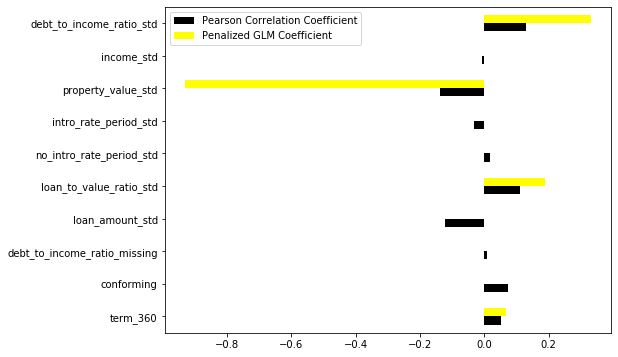

In [24]:
# collect Pearson correlation and GLM coefficients into same DataFrame
glm_selected_coef = pd.DataFrame.from_dict(best_glm.coef(), orient='index', columns=['Penalized GLM Coefficient'])
corr_glm = pd.concat([corr, glm_selected_coef.iloc[1:]], axis=1)

# plot
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = corr_glm.plot(kind='barh', ax=ax_, colormap='gnuplot')


The plot above compares Pearson Correlation Coefficients to Penalized GLM Coefficients. We focus on direction and magnitude. The direction of both coefficients match up which suggests the model is doing something right. The elastic net model selected three features that are positively correlated with high_priced and one feature that is negatively correlated with high_priced. One concern is that is gives an extremely high weight to property_value_std.

### Explainable Boosting Machine

#### Define utility function for random grid search

In [25]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

#### Fit EBM with random grid search

In [26]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8217.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

#### Basic AUC assessment

In [27]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8247.


#### Score validation data with EBM model

In [350]:
best_ebm.predict_proba(valid[x_names])

array([[0.82899052, 0.17100948],
       [0.67638602, 0.32361398],
       [0.97675838, 0.02324162],
       ...,
       [0.89966151, 0.10033849],
       [0.99599874, 0.00400126],
       [0.73671483, 0.26328517]])

In [82]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:,1], columns = ['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis = 1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.171009
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.323614
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.023242
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.015636
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004191


#### Select percentiles from prediction

In [83]:
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

0: 112323
10: 137011
20: 58140
30: 111885
40: 90824
50: 60393
60: 79952
70: 23873
80: 146633
90: 37573
99: 33940


#### Calculate EBM contributions

In [85]:
# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(valid[x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 25), columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))


#### Global feature importance

In [71]:
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()
global_fi

,GLM Importance,EBM Importance
term_360,0.068333,0.072928
conforming,0.000000,0.066810
debt_to_income_ratio_missing,0.000000,0.001282
loan_amount_std,0.000000,0.281158
loan_to_value_ratio_std,0.187592,0.906855
no_intro_rate_period_std,0.000000,0.063725
intro_rate_period_std,0.000000,0.108510
property_value_std,0.930194,0.432094
income_std,0.000000,0.168251
debt_to_income_ratio_std,0.330918,0.391460


#### Local feature importance

In [72]:
# extract scores at three percentiles of phat
# create mapping between validation row_id and Shapely array index values
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

for percentile in [10, 50, 90]:
 
    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(x_names)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df

local_fi_dict

{10:                              GLM Contribution  EBM Contribution
 term_360                            0.0683333         -0.911352
 conforming                                  0          0.035372
 debt_to_income_ratio_missing                0         -0.000652
 loan_amount_std                             0         -0.436448
 loan_to_value_ratio_std            -0.0424587         -1.186179
 no_intro_rate_period_std                    0         -0.033915
 intro_rate_period_std                      -0          0.029314
 property_value_std                  -0.906913         -0.438429
 income_std                                 -0          0.166355
 debt_to_income_ratio_std            -0.140683          0.052224,
 50:                              GLM Contribution  EBM Contribution
 term_360                            0.0683333          0.037092
 conforming                                  0          0.035372
 debt_to_income_ratio_missing                0         -0.000652
 loan_amount_std

In [28]:
train.groupby('high_priced').size()

high_priced
0    101326
1     10927
dtype: int64

#### Fitting models after addressing class imbalance

In [29]:
#Oversampling
rus = RandomOverSampler(random_state = SEED) 
# resampling X, y
X_train, y_train = rus.fit_resample(train[x_names], train[y_name])
# new class distribution
print(Counter(y_train))

Counter({0: 101326, 1: 101326})


#### Random oversampling EBM

In [73]:
ebm1 = ExplainableBoostingClassifier(random_state=SEED, n_jobs=-1)
ebm1.fit(X_train, y_train) 

ExplainableBoostingClassifier(feature_names=['term_360', 'conforming',
                                             'debt_to_income_ratio_missing',
                                             'loan_amount_std',
                                             'loan_to_value_ratio_std',
                                             'no_intro_rate_period_std',
                                             'intro_rate_period_std',
                                             'property_value_std', 'income_std',
                                             'debt_to_income_ratio_std',
                                             'loan_to_value_ratio_std x '
                                             'no_intro_rate_period_std',
                                             'loan_to_value_ratio_std x '
                                             'intro_rate_per...
                                             'property_value_std x income_std'],
                              feature_types=['categor

In [74]:
ebm_perf = ROC(ebm1.predict_proba).explain_perf(valid[x_names], valid[y_name], name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7001/116458812944/ -->

#### Basic AUC assessment

In [76]:
print('Validation AUC: %.6f.' % ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.824732.


#### Score validation data with oversampled EBM model

In [95]:
oversample_ebm_phat = pd.DataFrame(ebm1.predict_proba(valid[x_names])[:,1], columns = ['phat'])
oversample_ebm_phat = pd.concat([valid.reset_index(drop=True), oversample_ebm_phat], axis = 1)
oversample_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.610335
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.833058
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.161716
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.105971
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.035635


#### Select percentiles from prediction

In [97]:
oversample_ebm_percentiles = get_percentile_dict('phat', oversample_ebm_phat, 'row_id')
for key in sorted(oversample_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(oversample_ebm_percentiles[key]))

0: 112323
10: 77235
20: 126747
30: 132932
40: 30730
50: 119819
60: 78993
70: 149195
80: 147242
90: 30911
99: 97969


#### Calculate oversampled EBM contributions

In [98]:
# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
oversample_ebm_contribs = ebm1.explain_local(valid[x_names])
names = oversample_ebm_contribs._internal_obj['specific'][0]['names']
oversample_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(oversample_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 20), columns=names)
    oversample_ebm_contribs_df = oversample_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))


EBM contributions collected in 72.31 s.


#### Global feature importance

In [99]:
global_fi['Oversampled EBM Importance'] = np.abs(oversample_ebm_contribs_df).mean()
global_fi

,GLM Importance,EBM Importance,Oversampled EBM Importance
term_360,0.068333,0.072928,0.058902
conforming,0.000000,0.066810,0.062460
debt_to_income_ratio_missing,0.000000,0.001282,0.002273
loan_amount_std,0.000000,0.281158,0.268848
loan_to_value_ratio_std,0.187592,0.906855,0.991485
no_intro_rate_period_std,0.000000,0.063725,0.109550
intro_rate_period_std,0.000000,0.108510,0.105944
property_value_std,0.930194,0.432094,0.530347
income_std,0.000000,0.168251,0.217753
debt_to_income_ratio_std,0.330918,0.391460,0.412750


#### Local feature importance

In [107]:
# extract scores at three percentiles of phat
# create mapping between validation row_id and Shapely array index values
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

for percentile in [10, 50, 90]:
 
    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(oversample_ebm_percentiles[percentile])].index[0]
    s_df = oversample_ebm_contribs_df.iloc[idx, :len(x_names)].T
    s_df.columns = ['Oversample EBM Contribution']
    local_fi_dict[percentile]['Oversample EBM Contribution'] = s_df

local_fi_dict

{10:                              GLM Contribution  EBM Contribution  \
 term_360                            0.0683333         -0.911352   
 conforming                                  0          0.035372   
 debt_to_income_ratio_missing                0         -0.000652   
 loan_amount_std                             0         -0.436448   
 loan_to_value_ratio_std            -0.0424587         -1.186179   
 no_intro_rate_period_std                    0         -0.033915   
 intro_rate_period_std                      -0          0.029314   
 property_value_std                  -0.906913         -0.438429   
 income_std                                 -0          0.166355   
 debt_to_income_ratio_std            -0.140683          0.052224   
 
                               Oversample EBM Contribution  
 term_360                                         0.023473  
 conforming                                       0.025024  
 debt_to_income_ratio_missing                    -0.001314  
 l

#### Create h2o frames to use for GBM models

In [112]:
# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

In [113]:
htrain["high_priced"] = htrain["high_priced"].asfactor()
hvalid["high_priced"] = hvalid["high_priced"].asfactor()

### Basic GBM

In [303]:
#start local timer
basic_gbm_tic = time.time()
# Build and train the model:
pros_gbm = H2OGradientBoostingEstimator(nfolds=5,
                                        seed=SEED,
                                        keep_cross_validation_predictions = True)
pros_gbm.train(x=x_names, y=y_name, training_frame=htrain, validation_frame = hvalid)
# end local timer
basic_gbm_toc = time.time() - basic_gbm_tic
print('Simple GBM training completed in %.2f s.' % (basic_gbm_toc))

Simple GBM training completed in 23.79 s.


#### Basic AUC assessment

In [304]:
print('Validation AUC: %.4f.' % pros_gbm.auc(valid=True))

Validation AUC: 0.8214.


In [305]:
pros_gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1622566752875_3897


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,21381.0,5.0,5.0,5.0,21.0,32.0,29.34




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07592663427465941
RMSE: 0.27554788018538523
LogLoss: 0.2531028807486913
Mean Per-Class Error: 0.23681780948221354
AUC: 0.8261601818800974
AUCPR: 0.30832812046156294
Gini: 0.6523203637601949

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18405852232943068: 


,,0,1,Error,Rate
0,0,81205.0,20121.0,0.1986,(20121.0/101326.0)
1,1,3796.0,7131.0,0.3474,(3796.0/10927.0)
2,Total,85001.0,27252.0,0.2131,(23917.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.184059,0.373556,189.0
1,max f2,0.107590,0.541552,257.0
2,max f0point5,0.264522,0.327372,112.0
3,max accuracy,0.428262,0.903593,39.0
4,max precision,0.717635,1.000000,0.0
5,max recall,0.005520,1.000000,399.0
6,max specificity,0.717635,1.000000,0.0
7,max absolute_mcc,0.128667,0.325261,240.0
8,max min_per_class_accuracy,0.157552,0.748673,214.0
9,max mean_per_class_accuracy,0.100093,0.763182,264.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010093,0.368251,5.258902,5.258902,0.511915,0.430317,0.511915,0.430317,0.053080,0.053080,425.890223,425.890223,0.047622
1,2,0.020142,0.338747,3.743085,4.502670,0.364362,0.350840,0.438302,0.390666,0.037613,0.090693,274.308540,350.266986,0.078159
2,3,0.030315,0.312748,3.832132,4.277647,0.373030,0.324845,0.416397,0.368578,0.038986,0.129679,283.213243,327.764672,0.110079
3,4,0.040070,0.290269,3.161643,4.005965,0.307763,0.297786,0.389951,0.351344,0.030841,0.160520,216.164275,300.596501,0.133439
4,5,0.050092,0.282517,3.287358,3.862192,0.320000,0.286527,0.375956,0.338376,0.032946,0.193466,228.735792,286.219247,0.158835
5,6,0.100327,0.254880,2.708981,3.284767,0.263699,0.265183,0.319748,0.301728,0.136085,0.329551,170.898055,228.476732,0.253943
6,7,0.150357,0.225084,2.449348,3.006789,0.238426,0.238933,0.292689,0.280833,0.122540,0.452091,144.934799,200.678919,0.334273
7,8,0.200075,0.198543,2.269593,2.823598,0.220928,0.213100,0.274856,0.264002,0.112840,0.564931,126.959344,182.359806,0.404202
8,9,0.300063,0.157130,1.859829,2.502447,0.181041,0.179129,0.243595,0.235720,0.185961,0.750892,85.982919,150.244668,0.499446
9,10,0.400069,0.086757,1.216177,2.180915,0.118386,0.120886,0.212296,0.207015,0.121625,0.872518,21.617748,118.091519,0.523397




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.07522027101580939
RMSE: 0.2742631419199623
LogLoss: 0.25167673309593247
Mean Per-Class Error: 0.24010402638491168
AUC: 0.8213904014863387
AUCPR: 0.28681522354699246
Gini: 0.6427808029726774

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1854007768269543: 


,,0,1,Error,Rate
0,0,34966.0,8541.0,0.1963,(8541.0/43507.0)
1,1,1672.0,2906.0,0.3652,(1672.0/4578.0)
2,Total,36638.0,11447.0,0.2124,(10213.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.185401,0.362683,181.0
1,max f2,0.096062,0.531103,260.0
2,max f0point5,0.260499,0.309988,111.0
3,max accuracy,0.480588,0.905438,25.0
4,max precision,0.849767,1.000000,0.0
5,max recall,0.005573,1.000000,399.0
6,max specificity,0.849767,1.000000,0.0
7,max absolute_mcc,0.141857,0.316923,223.0
8,max min_per_class_accuracy,0.156754,0.745282,209.0
9,max mean_per_class_accuracy,0.082989,0.759896,273.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score:  9.73 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.366327,4.716746,4.716746,0.449064,0.431584,0.449064,0.431584,0.047182,0.047182,371.674618,371.674618,0.041091
1,2,0.020214,0.338428,3.914745,4.311620,0.372709,0.350183,0.410494,0.390465,0.039974,0.087156,291.474456,331.161985,0.073986
2,3,0.030009,0.308738,3.434264,4.025248,0.326964,0.323872,0.383229,0.368728,0.033639,0.120795,243.426375,302.524790,0.100339
3,4,0.040116,0.290269,3.068922,3.784307,0.292181,0.297313,0.360290,0.350736,0.031018,0.151813,206.892240,278.430742,0.123450
4,5,0.050078,0.283484,3.201483,3.668372,0.304802,0.286838,0.349252,0.338025,0.031892,0.183705,220.148281,266.837179,0.147687
5,6,0.100551,0.256066,2.756789,3.210789,0.262464,0.265625,0.305688,0.301683,0.139144,0.322848,175.678875,221.078916,0.245688
6,7,0.150088,0.225573,2.486974,2.971891,0.236776,0.240528,0.282943,0.281498,0.123198,0.446046,148.697362,197.189092,0.327100
7,8,0.200021,0.199074,2.252936,2.792414,0.214494,0.214027,0.265856,0.264655,0.112495,0.558541,125.293624,179.241388,0.396245
8,9,0.300073,0.157282,1.842642,2.475735,0.175431,0.179486,0.235706,0.236258,0.184360,0.742901,84.264181,147.573542,0.489424
9,10,0.400769,0.086147,1.264671,2.171445,0.120405,0.119692,0.206736,0.206970,0.127348,0.870249,26.467112,117.144538,0.518880




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07669461990111995
RMSE: 0.2769379351066227
LogLoss: 0.25598778779312586
Mean Per-Class Error: 0.24095909987026776
AUC: 0.8196794968381564
AUCPR: 0.2878705488803888
Gini: 0.6393589936763129

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1750077206182657: 


,,0,1,Error,Rate
0,0,79266.0,22060.0,0.2177,(22060.0/101326.0)
1,1,3522.0,7405.0,0.3223,(3522.0/10927.0)
2,Total,82788.0,29465.0,0.2279,(25582.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.175008,0.366657,207.0
1,max f2,0.108076,0.536128,265.0
2,max f0point5,0.260099,0.309558,124.0
3,max accuracy,0.502919,0.903040,26.0
4,max precision,0.740620,1.000000,0.0
5,max recall,0.005800,1.000000,398.0
6,max specificity,0.740620,1.000000,0.0
7,max absolute_mcc,0.136995,0.319543,240.0
8,max min_per_class_accuracy,0.154413,0.745035,227.0
9,max mean_per_class_accuracy,0.089442,0.759041,282.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010013,0.371464,4.706932,4.706932,0.458185,0.432391,0.458185,0.432391,0.047131,0.047131,370.693208,370.693208,0.041121
1,2,0.020008,0.337245,3.415175,4.061629,0.332442,0.352804,0.395370,0.392633,0.034136,0.081267,241.517520,306.162878,0.067864
2,3,0.030004,0.316887,3.699010,3.940828,0.360071,0.326591,0.383610,0.370632,0.036973,0.118239,269.901014,294.082767,0.097751
3,4,0.040008,0.297260,3.238326,3.765163,0.315227,0.306708,0.366511,0.354648,0.032397,0.150636,223.832565,276.516306,0.122558
4,5,0.050030,0.285601,3.013411,3.614572,0.293333,0.291037,0.351852,0.341905,0.030200,0.180836,201.341143,261.457179,0.144913
5,6,0.100024,0.252366,2.667098,3.141003,0.259622,0.266636,0.305753,0.304284,0.133339,0.314176,166.709756,214.100345,0.237246
6,7,0.150018,0.224907,2.529807,2.937320,0.246258,0.238610,0.285926,0.282398,0.126476,0.440652,152.980702,193.731970,0.321975
7,8,0.200021,0.200479,2.240182,2.763043,0.218065,0.212119,0.268962,0.264829,0.112016,0.552668,124.018244,176.304315,0.390676
8,9,0.300001,0.154612,1.880133,2.468801,0.183017,0.178829,0.240320,0.236168,0.187975,0.740642,88.013264,146.880082,0.488160
9,10,0.400141,0.088292,1.263904,2.167262,0.123032,0.120691,0.210967,0.207269,0.126567,0.867210,26.390446,116.726154,0.517438




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.77799666,0.007848542,0.7820747,0.77142096,0.77053106,0.78934854,0.77660805
1,auc,0.8198282,0.0030349477,0.8172719,0.81629694,0.8221856,0.8200618,0.8233249
2,err,0.22200336,0.007848542,0.21792533,0.22857907,0.22946893,0.21065147,0.22339197
3,err_count,4984.6,193.50272,4897.0,5130.0,5172.0,4695.0,5029.0
4,f0point5,0.29022935,0.009672327,0.28485882,0.28132048,0.28548968,0.305337,0.29414073
5,f1,0.36757573,0.008775097,0.35877964,0.360668,0.36539876,0.37954274,0.37348947
6,f2,0.5014322,0.010293676,0.48450983,0.50236076,0.5074291,0.50139666,0.5114644
7,lift_top_group,4.663888,0.38149536,4.931338,5.0446725,4.181142,4.337329,4.8249598
8,logloss,0.25599873,0.0035623338,0.25541258,0.25339234,0.25349182,0.26209635,0.25560063
9,max_per_class_error,0.33714595,0.025542079,0.36778957,0.31937912,0.3150874,0.3620613,0.3214124



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-06-03 12:20:47,18.481 sec,0.0,0.296424,0.319205,0.500000,0.097343,1.000000,0.902657,0.293508,0.314447,0.500000,0.095206,1.000000,0.904794
1,,2021-06-03 12:20:47,18.558 sec,1.0,0.293230,0.308905,0.797510,0.261015,4.155279,0.306076,0.290391,0.304476,0.794735,0.252789,4.100812,0.306748
2,,2021-06-03 12:20:47,18.630 sec,2.0,0.290638,0.300995,0.801165,0.266015,4.225712,0.265997,0.287879,0.296838,0.798549,0.257043,4.096966,0.270438
3,,2021-06-03 12:20:47,18.703 sec,3.0,0.288580,0.294875,0.805398,0.269793,4.227165,0.237597,0.285890,0.290915,0.803465,0.259708,4.101365,0.238557
4,,2021-06-03 12:20:47,18.781 sec,4.0,0.286755,0.289510,0.807836,0.274283,4.453405,0.234435,0.284123,0.285692,0.806139,0.263891,4.242996,0.234023
5,,2021-06-03 12:20:47,18.856 sec,5.0,0.285343,0.285312,0.808292,0.274640,4.295210,0.244127,0.282760,0.281623,0.806410,0.264873,4.251415,0.236061
6,,2021-06-03 12:20:47,18.936 sec,6.0,0.284164,0.281739,0.808881,0.275540,4.295210,0.243290,0.281614,0.278124,0.807342,0.266046,4.251415,0.244837
7,,2021-06-03 12:20:48,19.036 sec,7.0,0.283114,0.278519,0.809838,0.277935,4.440372,0.245152,0.280616,0.275000,0.808249,0.268654,4.492584,0.232255
8,,2021-06-03 12:20:48,19.155 sec,8.0,0.282313,0.275992,0.809968,0.278370,4.492770,0.245900,0.279843,0.272535,0.808382,0.269399,4.492584,0.243236
9,,2021-06-03 12:20:48,19.289 sec,9.0,0.281547,0.273544,0.811276,0.279811,4.523387,0.237196,0.279117,0.270166,0.809749,0.270195,4.504463,0.218842



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,3476.655762,1.000000,0.513486
1,property_value_std,1111.250610,0.319632,0.164127
2,debt_to_income_ratio_std,918.542358,0.264203,0.135664
3,loan_amount_std,526.373474,0.151402,0.077743
4,intro_rate_period_std,430.136749,0.123721,0.063529
5,income_std,124.122192,0.035702,0.018332
6,no_intro_rate_period_std,117.529999,0.033805,0.017359
7,term_360,34.778103,0.010003,0.005137
8,conforming,27.194498,0.007822,0.004017
9,debt_to_income_ratio_missing,4.108879,0.001182,0.000607


### Monotonic GBM with Grid Search

#### Create GBM grid search function

In [114]:
def gbm_grid(x_names, y_name, htrain, hvalid, seed_, weight=None,
             monotone_constraints_=None, hyper_params_=None,
             search_criteria_=None):

    """ Wrapper that trains a random grid of H2OGradientBoostingEstimators,
        optionally with user-designated monotonicity constraints, hyper_params,
        and search criteria.
    :param x_names: List of inputs.
    :param y_name: Name of target variable.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed_: Random seed for better reproducibility.
    :parem weight:
    :param monotone_constraints_: Dictionary of monotonicity constraints (optional).
    :param hyper_params_: Dictionary of hyperparamters over which to search (optional).
    :param search_criteria_: Dictionary of criterion for grid search (optional).
    :return: Best H2OGeneralizedLinearEstimator.
    """

    # define default random grid search parameters
    if monotone_constraints_ is not None:
            monotone_constraints_ = mono_constraints
    
    if hyper_params_ is None:

        hyper_params_ = {'ntrees': list(range(1, 500, 50)),
                         'max_depth': list(range(1, 20, 2)),
                         'sample_rate': [s / float(10) for s in range(1, 11)],
                         'col_sample_rate': [s / float(10) for s in range(1, 11)]}

    # define default search strategy
    if search_criteria_ is None:

        search_criteria_ = {'strategy': 'RandomDiscrete',
                            'max_models': 20,
                            'max_runtime_secs': 600,
                            'seed': seed_}

    # initialize grid search
    grid = H2OGridSearch(H2OGradientBoostingEstimator,
                         hyper_params=hyper_params_,
                         search_criteria=search_criteria_)

    # execute training w/ grid search
    grid.train(x=x_names,
               y=y_name,
               monotone_constraints=monotone_constraints_,
               training_frame=htrain,
               validation_frame=hvalid,
               stopping_rounds=5,
               weights_column=weight,
               seed=seed_)

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

In [115]:
# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])


#### This GBM with monotonic constraints differs from the other one because here we start with all features instead of the feautures that were significant in the elastic net model.

In [116]:
#start local timer
mono_gbm_tic = time.time()

mono_gbm = gbm_grid(x_names, y_name, htrain, hvalid,seed_=SEED)

#End local timer
mono_gbm_toc = time.time() - mono_gbm_tic
print('Monotonic GBM training completed in %.2f s.' % (mono_gbm_toc))

Monotonic GBM training completed in 223.87 s.


#### Basic AUC assessment

In [117]:
print('Best Monotonic GBM AUC: %.4f' % 
      mono_gbm.auc(valid=True))


Best Monotonic GBM AUC: 0.8234


#### Score validation data with Monotonic GBM

In [123]:
mono_gbm_phat = mono_gbm.predict(hvalid).as_data_frame()
mono_gbm_phat.drop(['predict','p0'], axis = 1, inplace =True)
mono_gbm_phat.columns = ['phat']
mono_gbm_phat = pd.concat([valid.reset_index(drop=True), mono_gbm_phat], axis=1)
mono_gbm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.172855
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.276247
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.028917
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.013134
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.005653


#### Select percentiles from predictions

In [124]:
mono_gbm_percentiles = get_percentile_dict('phat', mono_gbm_phat, 'row_id')
for key in sorted(mono_gbm_percentiles.keys()):
    print(str(key) + ': ' + str(mono_gbm_percentiles[key]))


0: 17713
10: 44282
20: 150610
30: 82510
40: 129683
50: 84570
60: 114197
70: 17434
80: 9215
90: 66653
99: 136360


#### Calculate Shapley values for Monotonic GBM predictions

In [173]:
shap_values = mono_gbm.predict_contributions(hvalid).as_data_frame().values[:, :-1]
shap_mono = pd.DataFrame(shap_values)
shap_mono

,0,1,2,3,4,5,6,7,8,9
0,0.015106,0.003308,-0.010655,0.133796,0.809596,-0.010553,0.002387,0.336823,-0.282231,0.203274
1,0.015804,0.004820,-0.010260,0.111838,0.983764,-0.007963,-0.005125,0.325007,0.092181,0.293153
2,0.016350,0.004367,-0.017054,-0.095191,-0.095101,-0.037415,-0.012595,-0.544002,0.001344,0.031706
3,0.002637,-0.002303,-0.033769,-0.012255,-1.238787,-0.060773,-0.050641,-0.406200,0.033548,0.215613
4,0.019406,0.002667,-0.049715,-0.154569,-1.120674,-0.072517,-0.066332,-0.659256,0.060419,-0.362950
...,...,...,...,...,...,...,...,...,...,...
48080,0.011535,0.004469,-0.039550,-0.019574,-1.124225,-0.054097,-0.039596,0.074641,0.030115,-0.406931
48081,0.015648,0.004311,-0.010746,-0.063312,-0.172195,-0.037648,-0.002925,-0.321237,0.003947,0.031437
48082,0.024405,0.007655,-0.011857,-0.005405,1.100028,-0.010822,0.008321,-0.201540,0.187283,-0.542196
48083,0.011790,0.004752,-0.050855,-0.143997,-1.055266,-0.061697,-0.073156,-0.864388,0.010850,0.017382


#### Plot Shapley values

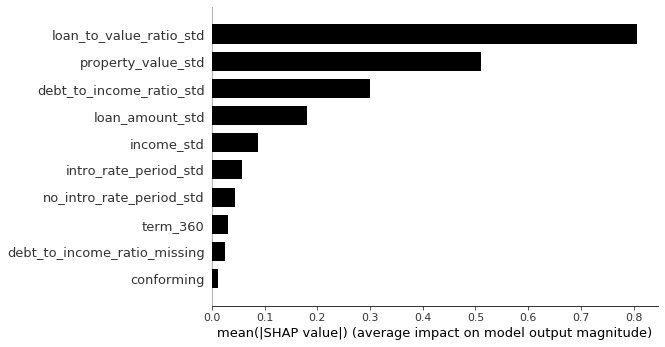

In [180]:
shap.summary_plot(shap_mono, x_names, plot_type='bar', color='k') # use shap package for nice bar plot


The chart above represents the mean absolute contribution a feature has on the monotonic GBM's predictions. We see the weights are quite skewed, with loan_to_value_ratio_std and property_value_std dominating feature importance in this model. This could cause issues in the future.

#### Global feature importance 

In [183]:
shap_mono.columns = x_names
global_fi['MGBM Importance'] = np.abs(shap_mono).mean()

#### Local feature importance

In [217]:
# collect SHAP values at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(mono_gbm_percentiles[percentile])].index[0]
    s_df = pd.DataFrame(shap_values[idx,:].T, columns=['MGBM Contribution'], index=x_names)
    local_fi_dict[percentile]['MGBM Contribution'] = 0
    local_fi_dict[percentile].update(s_df)

### GBM with Grid Search

#### We will not specify a monotonic constraint and we will use a different grid.

In [118]:
# GBM hyperparameters
gbm_params1 = {'learn_rate': [0.01, 0.1], 
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0]}

In [119]:
#start local timer
gbm_grid_tic = time.time()

gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x_names,y_name, 
                training_frame=htrain, 
                validation_frame=hvalid, 
                ntrees=100,
                seed=SEED)
#End local timer
gbm_grid_toc = time.time() - gbm_grid_tic
print('GBM with grid search training completed in %.2f s.' % (gbm_grid_toc))

GBM with grid search training completed in 254.41 s.


#### Ranking different models based on AUC

In [120]:
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)
print(gbm_gridperf1)

     col_sample_rate learn_rate max_depth sample_rate           model_ids  \
0                0.5        0.1         9         1.0  gbm_grid1_model_35   
1                0.5        0.1         9         0.8  gbm_grid1_model_17   
2                1.0        0.1         5         0.8  gbm_grid1_model_12   
3                1.0        0.1         9         0.8  gbm_grid1_model_18   
4                0.5        0.1         5         0.8  gbm_grid1_model_11   
5                1.0        0.1         9         1.0  gbm_grid1_model_36   
6                0.5        0.1         5         1.0  gbm_grid1_model_29   
7                1.0        0.1         5         1.0  gbm_grid1_model_30   
8                1.0       0.01         9         0.8  gbm_grid1_model_15   
9                0.5       0.01         9         0.8  gbm_grid1_model_14   
10               0.5       0.01         9         1.0  gbm_grid1_model_32   
11               0.2        0.1         9         0.8  gbm_grid1_model_16   

In [121]:
# Grab the model_id for the top GBM model, chosen by validation AUC
best_gbm_model1 = gbm_gridperf1.models[0]
best_gbm_model1

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_grid1_model_35


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,155002.0,0.0,9.0,4.48,1.0,371.0,118.67




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0721415189720421
RMSE: 0.26859173288104404
LogLoss: 0.2382816909972243
Mean Per-Class Error: 0.21397577403396673
AUC: 0.8546995064534598
AUCPR: 0.38509610630118146
Gini: 0.7093990129069196

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20177983589693585: 


,,0,1,Error,Rate
0,0,85733.0,15593.0,0.1539,(15593.0/101326.0)
1,1,4126.0,6801.0,0.3776,(4126.0/10927.0)
2,Total,89859.0,22394.0,0.1757,(19719.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.201780,0.408211,198.0
1,max f2,0.120466,0.569460,266.0
2,max f0point5,0.280579,0.386254,135.0
3,max accuracy,0.426367,0.906844,70.0
4,max precision,0.931941,1.000000,0.0
5,max recall,0.004540,1.000000,395.0
6,max specificity,0.931941,1.000000,0.0
7,max absolute_mcc,0.134163,0.357904,255.0
8,max min_per_class_accuracy,0.161060,0.769653,234.0
9,max mean_per_class_accuracy,0.106305,0.786024,277.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.423970,7.272511,7.272511,0.707925,0.532936,0.707925,0.532936,0.072756,0.072756,627.251098,627.251098,0.069518
1,2,0.020026,0.372382,4.711880,5.991056,0.458667,0.393393,0.583185,0.463103,0.047222,0.119978,371.187969,499.105626,0.110731
2,3,0.030021,0.338103,4.257524,5.413898,0.414439,0.354612,0.527003,0.426982,0.042555,0.162533,325.752405,441.389806,0.146802
3,4,0.040008,0.314063,3.619833,4.966081,0.352364,0.325696,0.483411,0.401700,0.036149,0.198682,261.983268,396.608080,0.175786
4,5,0.050003,0.299691,3.415175,4.656065,0.332442,0.306071,0.453234,0.382584,0.034136,0.232818,241.517520,365.606547,0.202529
5,6,0.100024,0.255102,3.044392,3.850085,0.296349,0.274058,0.374777,0.328312,0.152283,0.385101,204.439202,285.008520,0.315820
6,7,0.150072,0.226872,2.485048,3.394857,0.241901,0.240200,0.330464,0.298927,0.124371,0.509472,148.504773,239.485663,0.398158
7,8,0.200012,0.200892,2.288792,3.118685,0.222797,0.213902,0.303581,0.277697,0.114304,0.623776,128.879217,211.868536,0.469462
8,9,0.300161,0.148959,1.728919,2.654990,0.168297,0.175957,0.258444,0.243752,0.173149,0.796925,72.891867,165.498983,0.550335
9,10,0.399998,0.086028,1.158657,2.281515,0.112787,0.116057,0.222089,0.211880,0.115677,0.912602,15.865653,128.151469,0.567883




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.07498914941234473
RMSE: 0.27384146766394735
LogLoss: 0.25024806613340816
Mean Per-Class Error: 0.23745707582264086
AUC: 0.82378921353431
AUCPR: 0.293014708515559
Gini: 0.64757842706862

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17230667961946017: 


,,0,1,Error,Rate
0,0,34091.0,9416.0,0.2164,(9416.0/43507.0)
1,1,1445.0,3133.0,0.3156,(1445.0/4578.0)
2,Total,35536.0,12549.0,0.2259,(10861.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.172307,0.365855,220.0
1,max f2,0.104995,0.534847,274.0
2,max f0point5,0.232546,0.310608,163.0
3,max accuracy,0.654795,0.905417,17.0
4,max precision,0.866300,1.000000,0.0
5,max recall,0.003646,1.000000,397.0
6,max specificity,0.866300,1.000000,0.0
7,max absolute_mcc,0.104995,0.318731,274.0
8,max min_per_class_accuracy,0.148674,0.746845,239.0
9,max mean_per_class_accuracy,0.089922,0.762543,288.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score:  9.69 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.412372,4.913277,4.913277,0.467775,0.517838,0.467775,0.517838,0.049148,0.049148,391.327728,391.327728,0.043264
1,2,0.020027,0.369611,4.031424,4.471893,0.383817,0.389619,0.425753,0.453662,0.040411,0.089559,303.142442,347.189298,0.076848
2,3,0.030009,0.335571,3.391754,4.112595,0.322917,0.352243,0.391545,0.419926,0.033858,0.123416,239.175359,311.259505,0.103236
3,4,0.040012,0.311718,2.707762,3.761387,0.257796,0.322256,0.358108,0.395508,0.027086,0.150502,170.776170,276.138671,0.122116
4,5,0.050036,0.296688,3.050808,3.619035,0.290456,0.303727,0.344555,0.377121,0.030581,0.181083,205.080767,261.903464,0.144836
5,6,0.100010,0.254087,2.823661,3.221596,0.268831,0.273218,0.306717,0.325202,0.141110,0.322193,182.366115,222.159598,0.245562
6,7,0.150005,0.226607,2.599659,3.014312,0.247504,0.239907,0.286982,0.296775,0.129969,0.452163,159.965870,201.431230,0.333952
7,8,0.200021,0.200766,2.188046,2.807703,0.208316,0.213690,0.267311,0.275999,0.109436,0.561599,118.804615,180.770281,0.399625
8,9,0.300010,0.148257,1.856899,2.490812,0.176789,0.175708,0.237141,0.242573,0.185671,0.747270,85.689907,149.081217,0.494322
9,10,0.400021,0.085584,1.258061,2.182608,0.119775,0.114897,0.207798,0.210653,0.125819,0.873089,25.806053,118.260824,0.522846




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-06-02 12:45:51,3 min 58.648 sec,0.0,0.296424,0.319205,0.500000,0.097343,1.000000,0.902657,0.293508,0.314447,0.500000,0.095206,1.000000,0.904794
1,,2021-06-02 12:45:51,3 min 58.742 sec,1.0,0.292525,0.306887,0.820574,0.297835,4.832668,0.217250,0.289966,0.303269,0.805213,0.261895,4.130015,0.220173
2,,2021-06-02 12:45:51,3 min 58.846 sec,2.0,0.289364,0.297669,0.824992,0.310552,5.368977,0.206471,0.287124,0.294894,0.810491,0.270901,4.436259,0.223625
3,,2021-06-02 12:45:52,3 min 59.009 sec,3.0,0.286809,0.290488,0.827612,0.316673,5.533695,0.213883,0.284854,0.288359,0.813433,0.275922,4.572363,0.219341
4,,2021-06-02 12:45:52,3 min 59.166 sec,4.0,0.284583,0.284399,0.830739,0.324457,5.779129,0.193768,0.282975,0.283002,0.815354,0.279588,4.501498,0.216908
5,,2021-06-02 12:45:52,3 min 59.442 sec,5.0,0.282728,0.279288,0.832910,0.327814,5.765729,0.215451,0.281385,0.278415,0.817566,0.283241,4.467744,0.226432
6,,2021-06-02 12:45:52,3 min 59.668 sec,6.0,0.281057,0.274690,0.834391,0.331205,5.898981,0.216520,0.280037,0.274457,0.818284,0.284119,4.498378,0.219320
7,,2021-06-02 12:45:52,3 min 59.849 sec,7.0,0.279648,0.270802,0.835614,0.334129,5.916031,0.211344,0.278932,0.271146,0.818993,0.285029,4.507325,0.223396
8,,2021-06-02 12:45:53,4 min 0.028 sec,8.0,0.278461,0.267465,0.836878,0.336551,6.085681,0.206427,0.278030,0.268356,0.819481,0.286221,4.696173,0.213788
9,,2021-06-02 12:45:53,4 min 0.166 sec,9.0,0.277483,0.264683,0.837477,0.338411,6.117223,0.208832,0.277304,0.266009,0.819931,0.287130,4.738583,0.222127



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,3388.929932,1.000000,0.394752
1,property_value_std,1511.641235,0.446053,0.176080
2,debt_to_income_ratio_std,1328.435547,0.391993,0.154740
3,loan_amount_std,911.447571,0.268948,0.106168
4,income_std,709.055359,0.209227,0.082593
5,intro_rate_period_std,531.960083,0.156970,0.061964
6,no_intro_rate_period_std,88.260742,0.026044,0.010281
7,term_360,70.060158,0.020673,0.008161
8,conforming,38.792511,0.011447,0.004519
9,debt_to_income_ratio_missing,6.383875,0.001884,0.000744


#### Score validation data with GBM

In [220]:
gbm_model_phat = best_gbm_model1.predict(hvalid).as_data_frame()
gbm_model_phat.drop(['predict','p0'], axis = 1, inplace =True)
gbm_model_phat.columns = ['phat']
gbm_model_phat = pd.concat([valid.reset_index(drop=True), gbm_model_phat], axis=1)
gbm_model_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.191695
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.285438
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.020010
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.012104
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.005548


#### Select percentiles from predictors

In [221]:
gbm_model_percentiles = get_percentile_dict('phat', gbm_model_phat, 'row_id')
for key in sorted(gbm_model_percentiles.keys()):
    print(str(key) + ': ' + str(gbm_model_percentiles[key]))


0: 112323
10: 681
20: 53811
30: 102888
40: 60666
50: 100732
60: 53384
70: 93141
80: 22562
90: 18874
99: 33505


#### Calculate Shapley values for GBM

In [222]:
shap_values2 = best_gbm_model1.predict_contributions(hvalid).as_data_frame().values[:, :-1]
shap_gbm = pd.DataFrame(shap_values2)
shap_gbm

,0,1,2,3,4,5,6,7,8,9
0,0.018860,0.006761,-0.000255,0.262179,0.988649,-0.008737,0.005154,0.448273,-0.291648,0.241278
1,0.020903,0.007029,-0.000230,0.186685,1.216427,-0.010169,0.007769,0.293778,0.111988,0.357727
2,0.007351,0.010125,-0.000791,-0.271679,-0.040143,-0.047728,0.009025,-0.348465,-0.074130,-0.025332
3,0.014451,-0.001921,-0.000362,0.012106,-1.326321,-0.048414,-0.039091,-0.178265,0.012602,0.262712
4,0.026358,0.010632,-0.000953,-0.212823,-1.213404,-0.058741,-0.038824,-0.284884,0.051193,-0.357801
...,...,...,...,...,...,...,...,...,...,...
48080,0.019003,0.006338,-0.000583,0.156273,-1.076741,-0.039572,-0.008867,0.393132,0.054235,-0.493638
48081,0.008176,0.011157,-0.000387,-0.076025,-0.153292,-0.029019,0.004293,-0.065687,-0.019909,0.003473
48082,0.027671,0.020082,-0.000433,-0.032445,1.314150,-0.010250,0.016905,-0.090552,0.168824,-0.652933
48083,0.013612,-0.004665,-0.001057,-0.282713,-1.169113,-0.068066,-0.029546,-0.540882,-0.058577,0.072095


#### Plot Shapley values

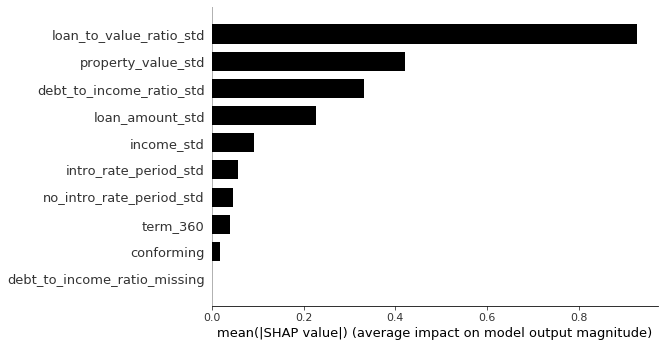

In [223]:
shap.summary_plot(shap_gbm, x_names, plot_type='bar', color='k') # use shap package for nice bar plot


Similar to the monotonic GBM, this GBM model also places heavy emphasis on loan_to_value_ratio_std and property_value_std. This model places even more emphasis on loan_to_value_ratio_std.

#### Global feature importance

In [224]:
shap_gbm.columns = x_names
global_fi['GBM Importance'] = np.abs(shap_gbm).mean()

#### Local feature importance

In [226]:
# collect SHAP values at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(gbm_model_percentiles[percentile])].index[0]
    s_df = pd.DataFrame(shap_values2[idx,:].T, columns=['GBM Contribution'], index=x_names)
    local_fi_dict[percentile]['GBM Contribution'] = 0
    local_fi_dict[percentile].update(s_df)

#### Basic AUC assessment

In [229]:
print('Validation AUC: %.4f.' % best_gbm_model1.auc(valid=True))

Validation AUC: 0.8238.


### Analyze feature importance

#### Analyze global feature importance across different models

In [351]:
global_fi

,GLM Importance,EBM Importance,Oversampled EBM Importance,MGBM Importance,GBM Importance
term_360,0.068333,0.072928,0.058902,0.030616,0.040127
conforming,0.000000,0.066810,0.062460,0.011282,0.017438
debt_to_income_ratio_missing,0.000000,0.001282,0.002273,0.024284,0.000949
loan_amount_std,0.000000,0.281158,0.268848,0.179908,0.227133
loan_to_value_ratio_std,0.187592,0.906855,0.991485,0.806216,0.926892
no_intro_rate_period_std,0.000000,0.063725,0.109550,0.044230,0.045652
intro_rate_period_std,0.000000,0.108510,0.105944,0.056909,0.056632
property_value_std,0.930194,0.432094,0.530347,0.510114,0.421814
income_std,0.000000,0.168251,0.217753,0.086685,0.092788
debt_to_income_ratio_std,0.330918,0.391460,0.412750,0.299799,0.331820


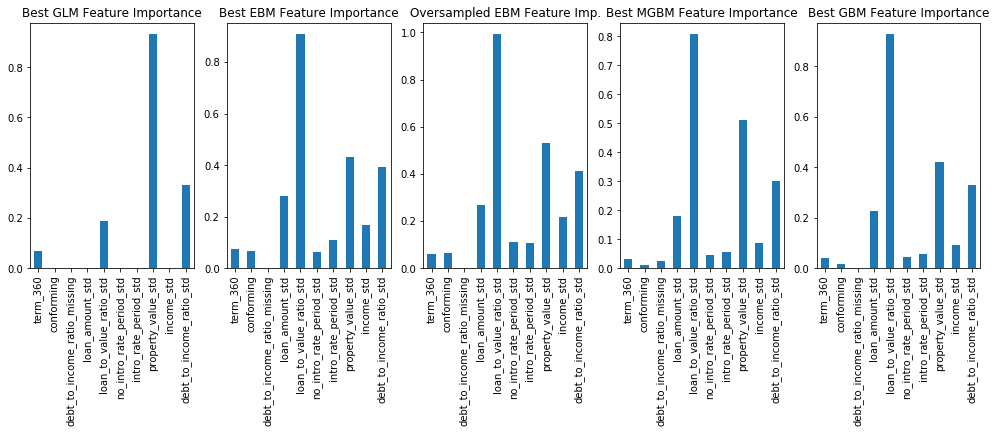

In [352]:
# init 5-pane plot 
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(ncols=5)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot global FI across three panes
_ = global_fi['GLM Importance'].plot(kind='bar', ax=ax0, title='Best GLM Feature Importance')
_ = global_fi['EBM Importance'].plot(kind='bar', ax=ax1, title='Best EBM Feature Importance')
_ = global_fi['Oversampled EBM Importance'].plot(kind='bar', ax=ax2, title='Oversampled EBM Feature Imp.')
_ = global_fi['MGBM Importance'].plot(kind='bar', ax=ax3, title='Best MGBM Feature Importance')
_ = global_fi['GBM Importance'].plot(kind='bar', ax=ax4, title='Best GBM Feature Importance')


We have plotted the feature importance of five selected models. The GLM ealstic net model differs greatly from the other four models, and it also performs much worse than the other models. The GLM uses the L1 penalty for variable selection and selects four feautures. An interesting note is that the GLM model did not select loan_to_value_ratio_std which turned out to have the alrgest feature importance for the other four models. The other four models all have the same top three features in the following order: loan_to_value_ratio_std, property_value_std, and debt_to_income_ratio_std.   

#### Analyze local feature importance across models

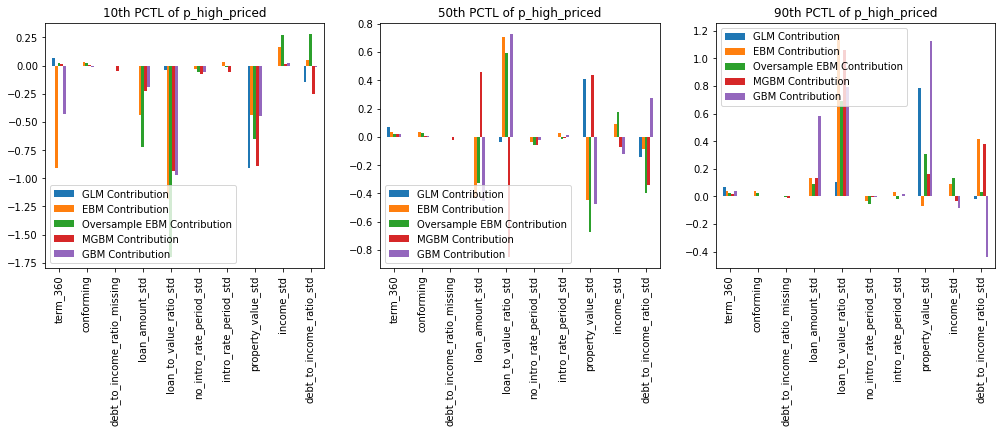

In [246]:
# init 3-pane plot
fig, (ax0, ax1, ax2) =plt.subplots(ncols=3)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot local FI across three panes
_ = local_fi_dict[10].plot(kind='bar', ax=ax0, title = '10th PCTL of p_high_priced')
_ = local_fi_dict[50].plot(kind="bar", ax=ax1, title = '50th PCTL of p_high_priced')
_ = local_fi_dict[90].plot(kind="bar", ax=ax2, title = '90th PCTL of p_high_priced')

When moving from low percentiles of probability of high_priced to higher percentiles, contribution of features tend to move from negative to positive. This makes sense for features that have to do with things that are detrimental to your finances like unpaid loans and debt. At the 10th percentile of high_priced, loan_to_value_ratio_std has a strong negative contribution while income_std has a positive contribution. At the 90th percentile of high_priced, loan_to_value_ratio_std has a strong positive contribution to high_priced.

#### Utility function for partial dependence

In [247]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'h2o':
        temp_df['partial_dependence'] = model.predict(h2o.H2OFrame(temp_df))['p1'].as_data_frame()
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(xgb.DMatrix(temp_df), iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

#### Partial dependence for all X and models

In [254]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:
    
    print('Calculating partial dependence for %s ...' % name)
    
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'glm', 'gbm', 'mgbm', 'ebm','oversample ebm'])
    first_pd = par_dep(name, valid[x_names], best_glm, 'h2o')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['glm'] = first_pd['partial_dependence']
    
    # calculate par dep for remaining models
    pd_dict[name]['gbm'] = par_dep(name, valid[x_names], best_gbm_model1, 'h2o', bins=bins)['partial_dependence']
    pd_dict[name]['mgbm'] = par_dep(name, valid[x_names], mono_gbm, 'h2o', bins=bins)['partial_dependence']
    pd_dict[name]['ebm'] = par_dep(name, valid[x_names], best_ebm, 'ebm', bins=bins)['partial_dependence']
    pd_dict[name]['oversample ebm'] = par_dep(name, valid[x_names], ebm1, 'ebm', bins=bins)['partial_dependence']
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Done.
Partial dependence calculated in 72.31 s.


#### Plot partial dependence for all features and models

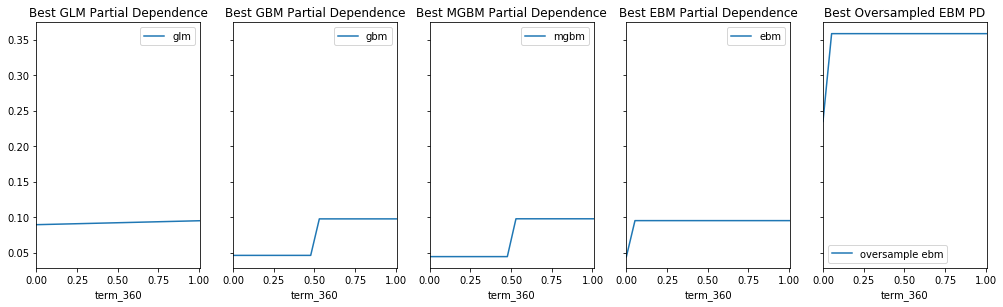

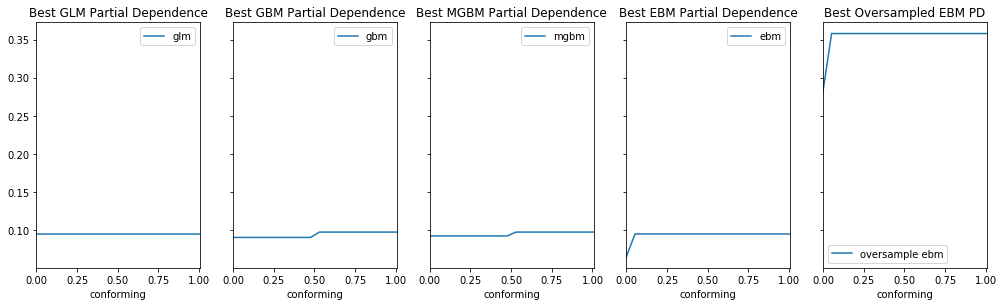

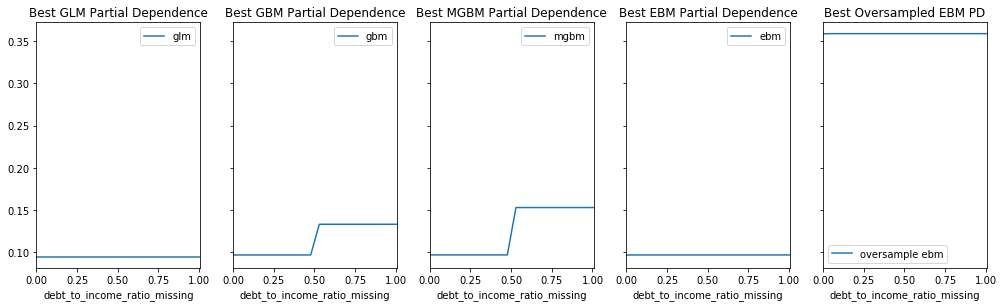

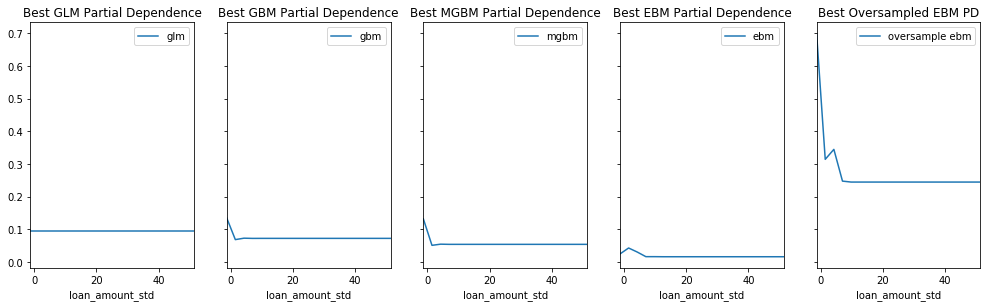

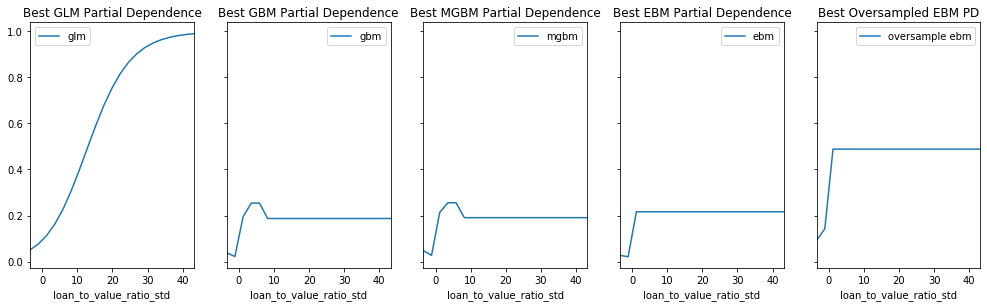

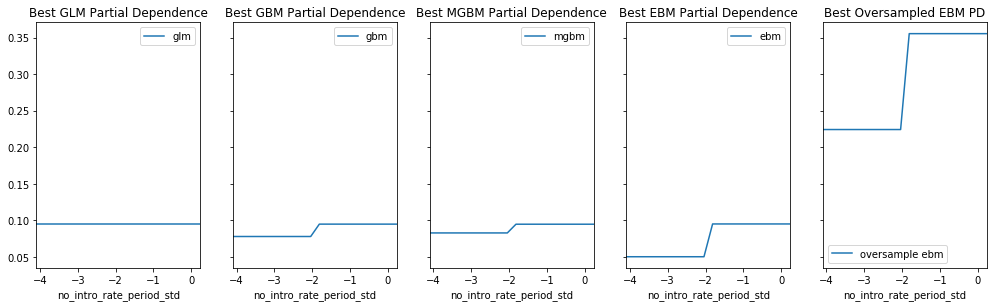

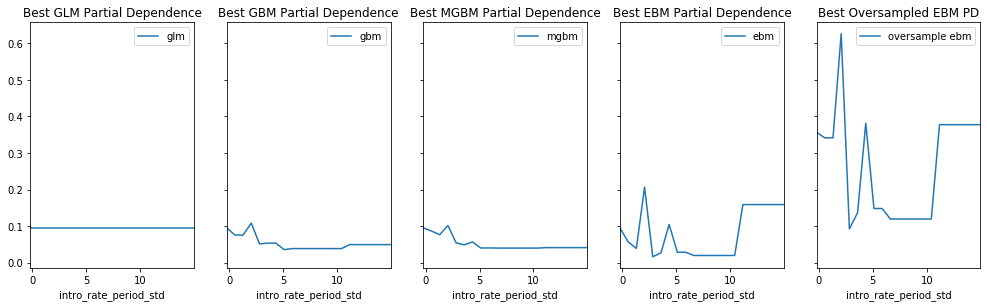

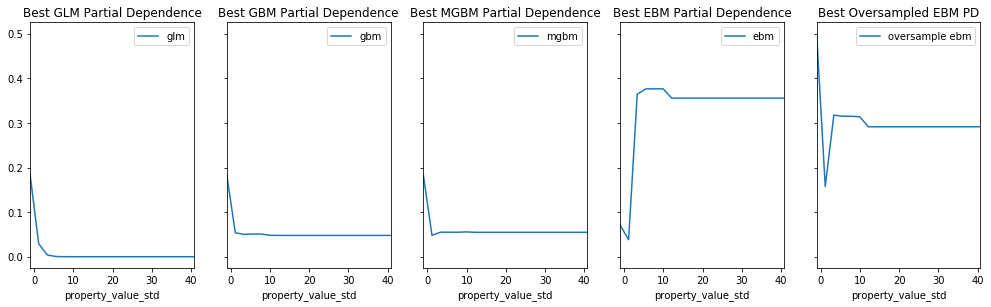

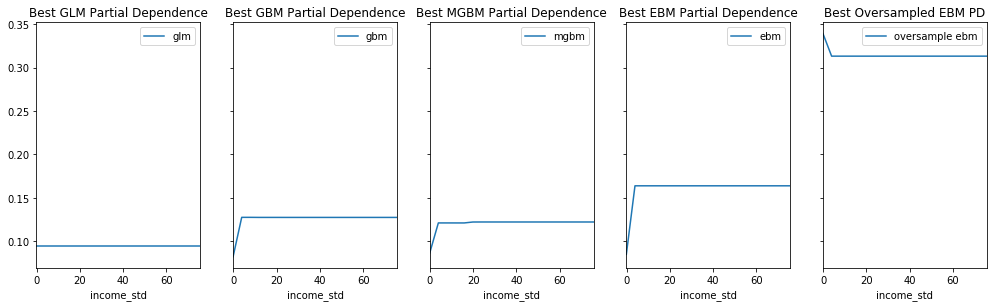

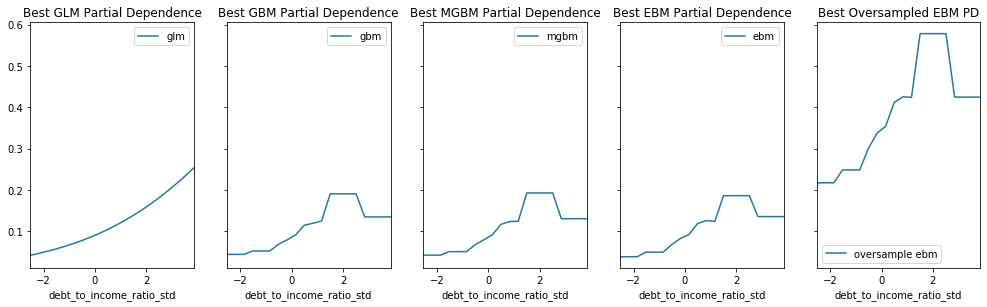

In [259]:
# loop through names to calculate par dep 
for name in x_names:
    
    # init 5-pane plot
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(ncols=5, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)
  
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='glm', ax=ax0, title='Best GLM Partial Dependence')
    ax0.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='gbm', ax=ax1, title='Best GBM Partial Dependence') 
    ax1.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='mgbm', ax=ax2, title='Best MGBM Partial Dependence') 
    ax2.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='ebm', ax=ax3, title='Best EBM Partial Dependence')
    ax3.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='oversample ebm', ax=ax4, title='Best Oversampled EBM PD')
    ax4.set_xlabel(name)

Partial dependence plots show the estimated average behavior of a specified variable under different models.

#### Calculate partial dependence for each feature in GBM model

In [264]:
# init dict to hold partial dependence and ICE values
# for each feature
# for gbm
gbm_pd_ice_dict = {}

# calculate partial dependence for each selected feature
for xs in x_names: 
    gbm_pd_ice_dict[xs] = explain.pd_ice(xs, valid, best_gbm_model1)

#### Find some percentiles of predicted values in validation data

In [271]:
# merge GBM predictions onto test data
gbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             best_gbm_model1.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                            axis=1)

# rename yhat column
gbm_yhat_valid = gbm_yhat_valid.rename(columns={'p1':'p_HIGH_PRICED'})

# find percentiles of predictions
gbm_percentile_dict = explain.get_percentile_dict('p_HIGH_PRICED', gbm_yhat_valid, 'row_id')

# display percentiles dictionary
# key=percentile, val=ID
gbm_percentile_dict

{0: 112323,
 99: 33505,
 10: 681,
 20: 53811,
 30: 102888,
 40: 60666,
 50: 100732,
 60: 53384,
 70: 93141,
 80: 22562,
 90: 18874}

#### Calculate ICE curve values

In [274]:
# loop through selected features
for xs in x_names: 

    # collect bins used in partial dependence
    bins = list(gbm_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(gbm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        gbm_pd_ice_dict[xs][col_name] = explain.pd_ice(xs, 
                                                        valid[valid['row_id'] == int(gbm_percentile_dict[i])][x_names], 
                                                        best_gbm_model1, 
                                                        bins=bins)['partial_dependence']

In [333]:
gbm_pd_ice_dict

{'term_360':     term_360  partial_dependence  Percentile_0  Percentile_10  Percentile_20  \
 0      0.000            0.046122      0.001850       0.005500       0.006999   
 1      0.053            0.046122      0.001850       0.005500       0.006999   
 2      0.106            0.046122      0.001850       0.005500       0.006999   
 3      0.159            0.046122      0.001850       0.005500       0.006999   
 4      0.212            0.046122      0.001850       0.005500       0.006999   
 5      0.265            0.046122      0.001850       0.005500       0.006999   
 6      0.318            0.046122      0.001850       0.005500       0.006999   
 7      0.371            0.046122      0.001850       0.005500       0.006999   
 8      0.424            0.046122      0.001850       0.005500       0.006999   
 9      0.477            0.046122      0.001850       0.005500       0.006999   
 10     0.530            0.097563      0.002164       0.006203       0.007621   
 11     0.583   

#### Assess partial dependence and ICE for each feature in GBM

It is only working for three features, not sure why this is happening.

KeyError: 

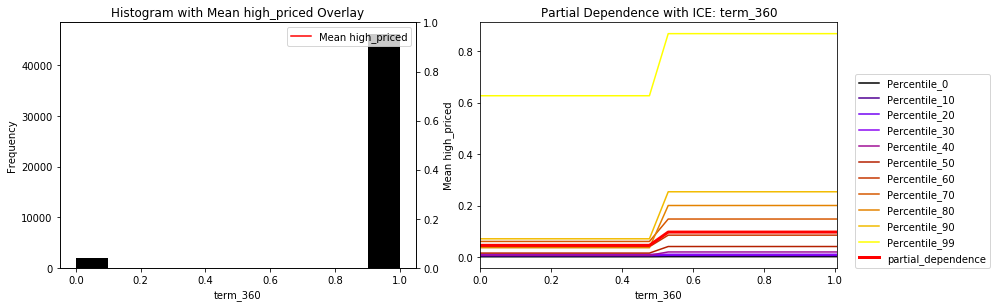

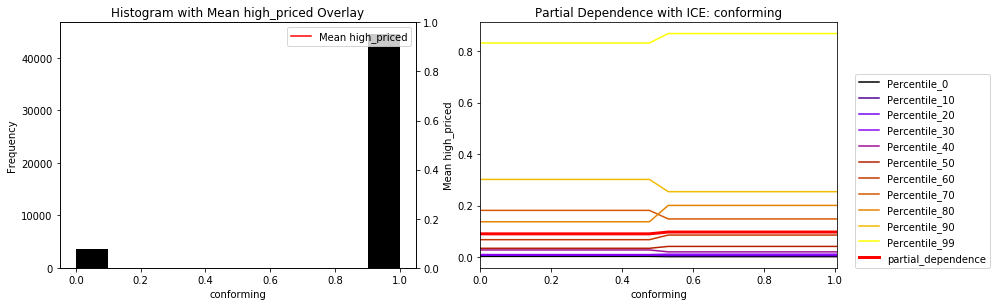

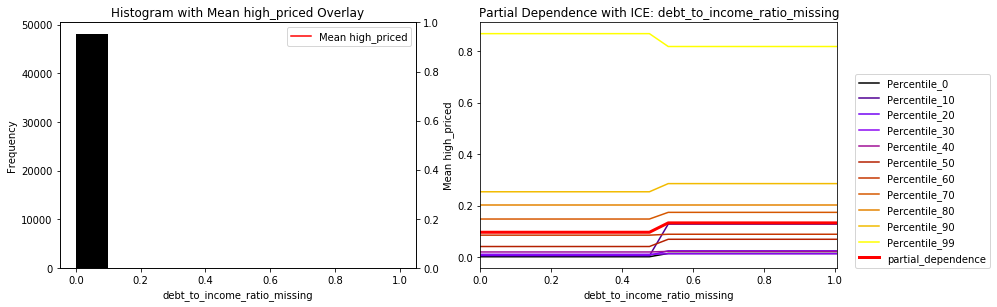

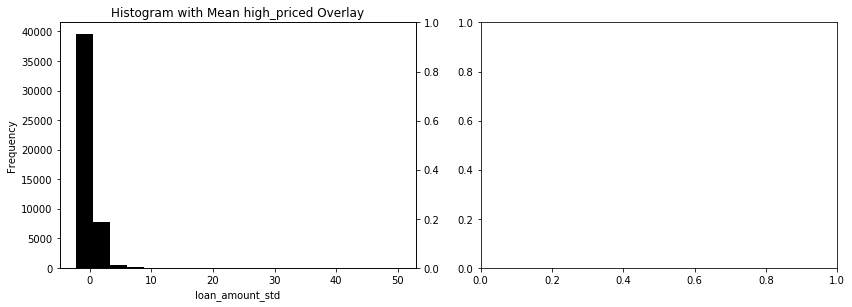

In [276]:
for xs in x_names: 
    explain.hist_mean_pd_ice_plot(xs, y_name, valid, gbm_pd_ice_dict)

#### Partial Dependence with sklearn

Trying to use sklearn's PD plot feature, but was given the error message: "dtype is only supported for one column frames"

In [283]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

In [321]:
print('Plotting Partial Dependence and ICE')
pd_tic = time.time()

pd_ice_plot = plot_partial_dependence(pros_gbm.train(x=x_names, y=y_name, training_frame=htrain), htrain[x_names], x_names, kind = "both", random_state=SEED)

print(f"completed in {time.time() - pd_tic:.3f}s")

pd_ice_plot.figure_.suptitle("Partial Dependence and ICE plots of GBM model")
pd_ice_plot.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

Plotting Partial Dependence and ICE


H2OValueError: dtype is only supported for one column frames

#### Automatically generates explanation tables and graphs for an h2o model.

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## best_grid_gbm


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20177983589693585: 


,,0,1,Error,Rate
0,0,85733.0,15593.0,0.1539,(15593.0/101326.0)
1,1,4126.0,6801.0,0.3776,(4126.0/10927.0)
2,Total,89859.0,22394.0,0.1757,(19719.0/112253.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

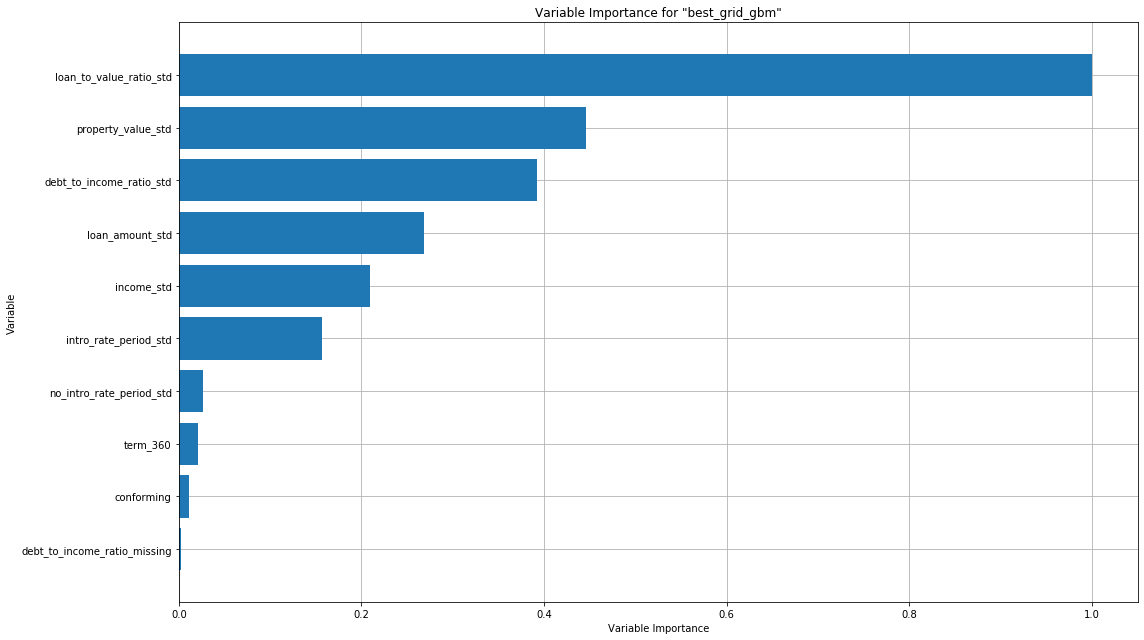

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

invalid value encountered in true_divide


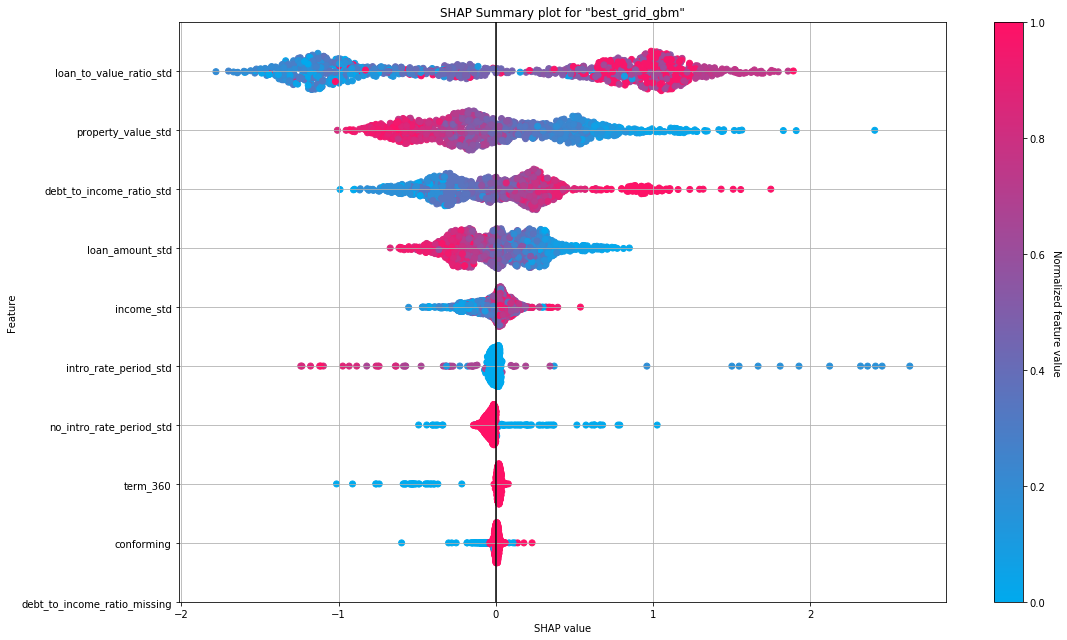

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

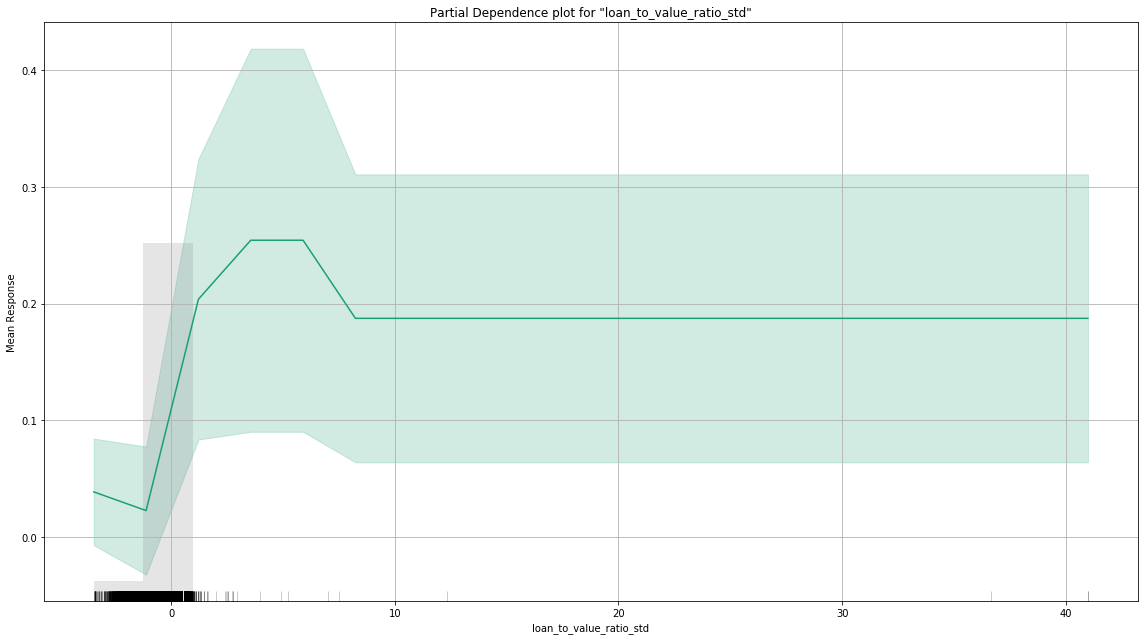

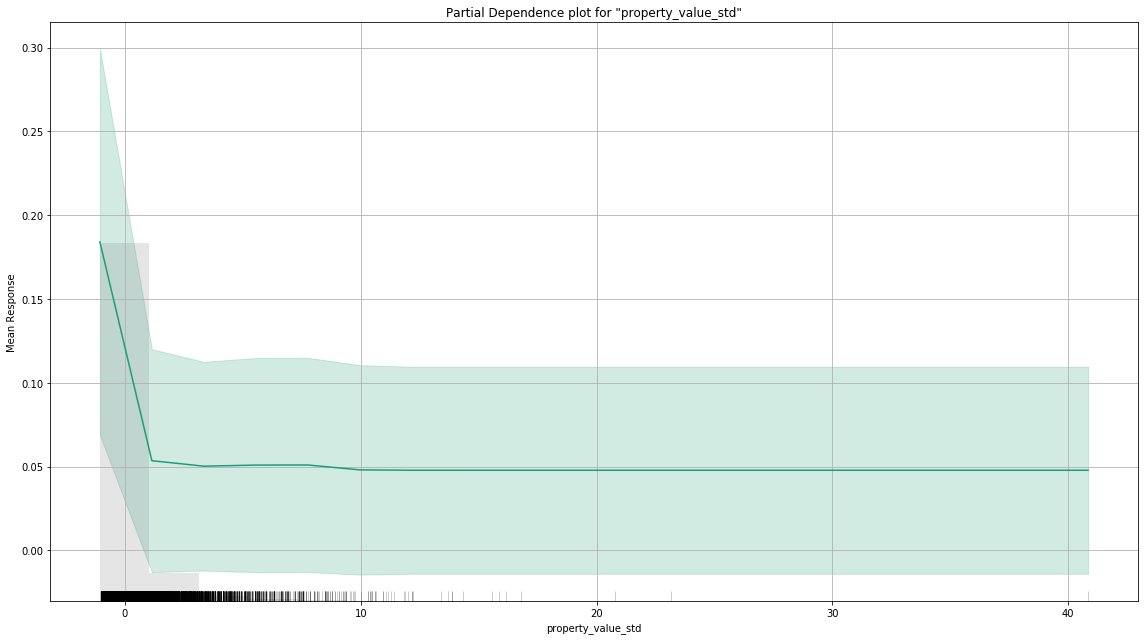

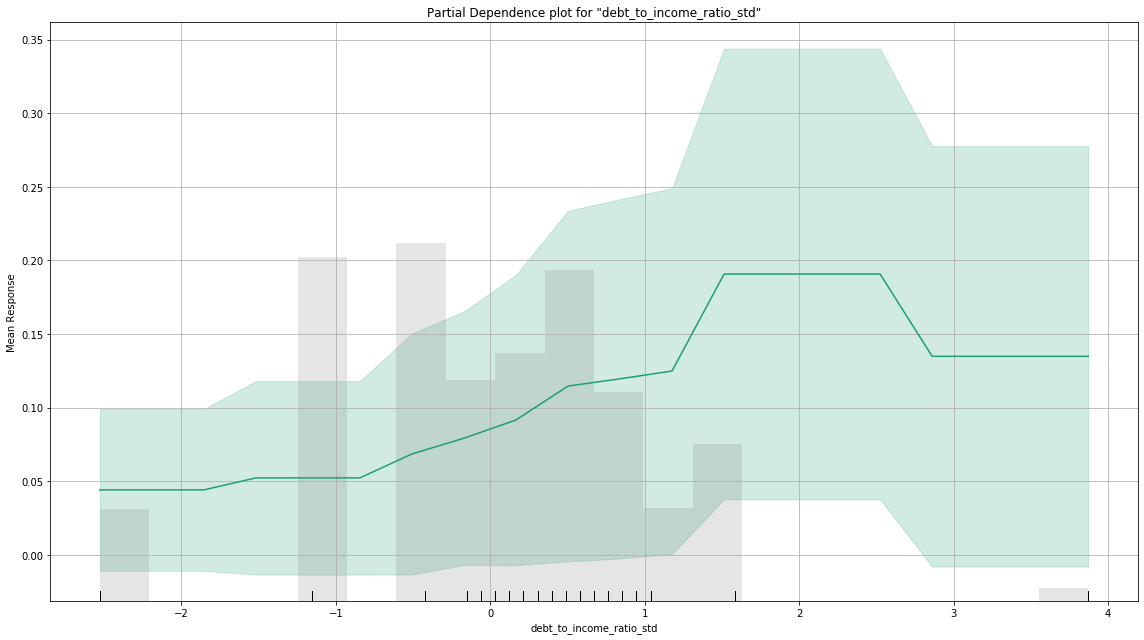

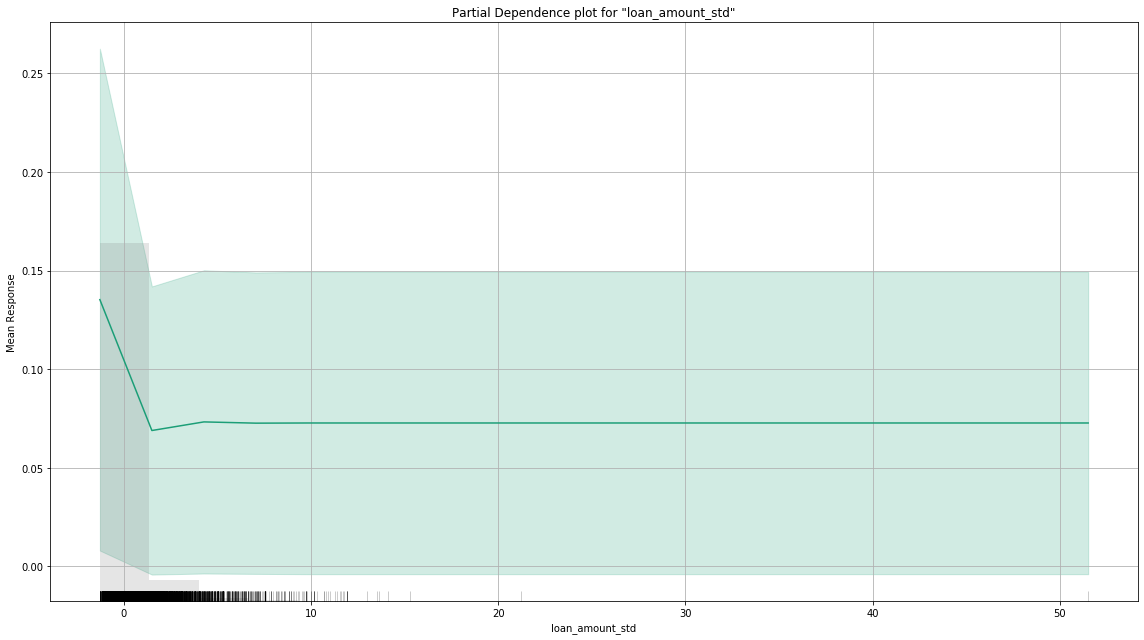

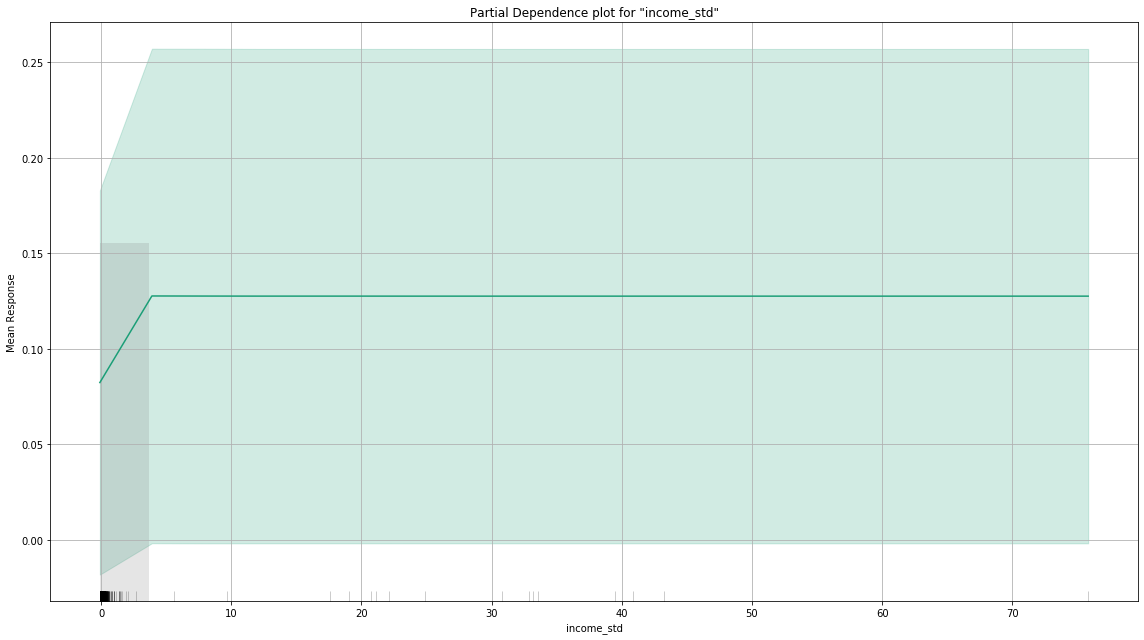

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## best_grid_gbm


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20177983589693585: 


,,0,1,Error,Rate
0,0,85733.0,15593.0,0.1539,(15593.0/101326.0)
1,1,4126.0,6801.0,0.3776,(4126.0/10927.0)
2,Total,89859.0,22394.0,0.1757,(19719.0/112253.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

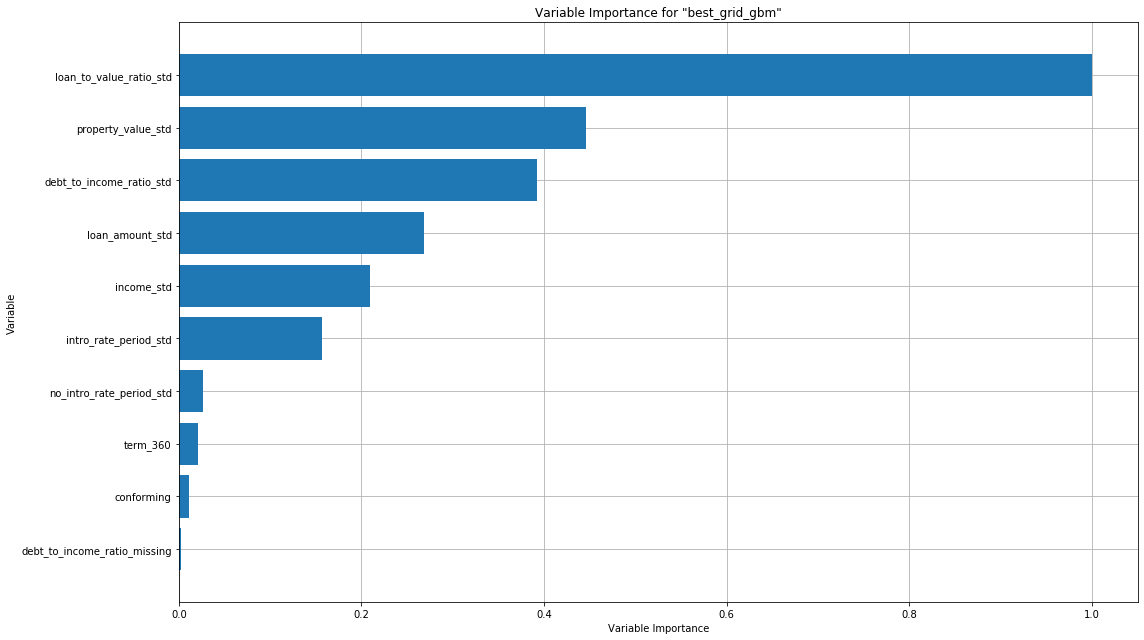

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

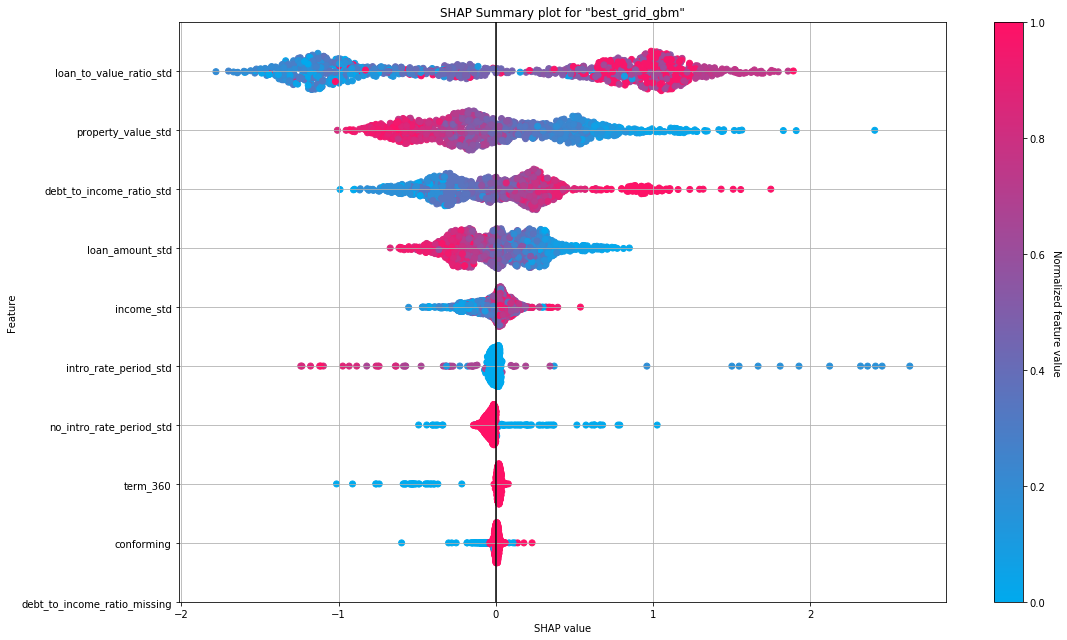

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

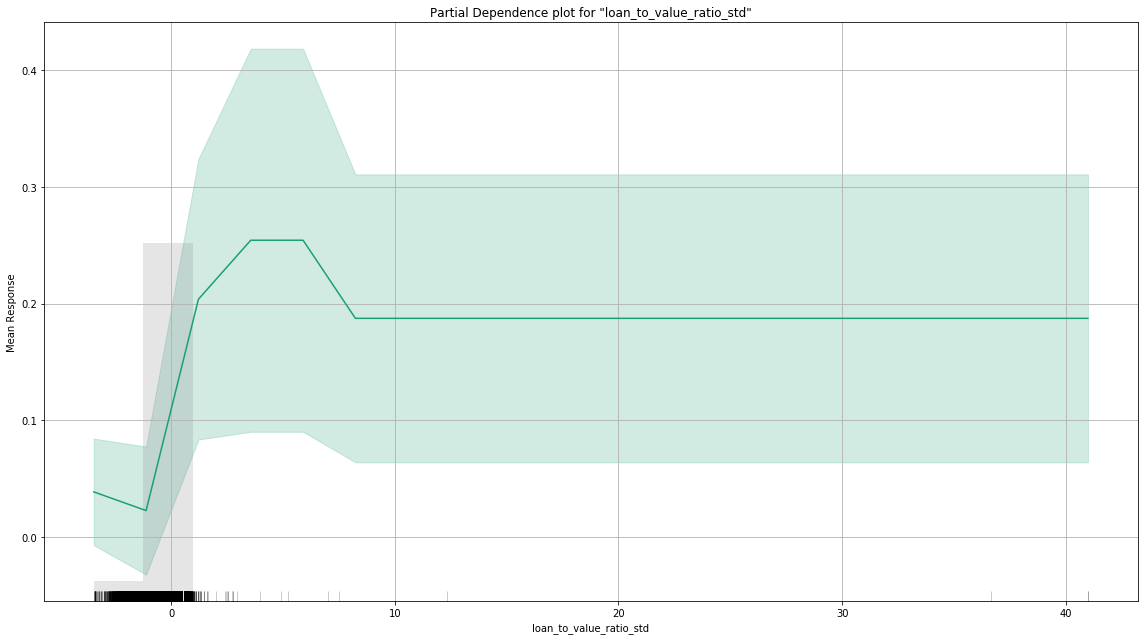

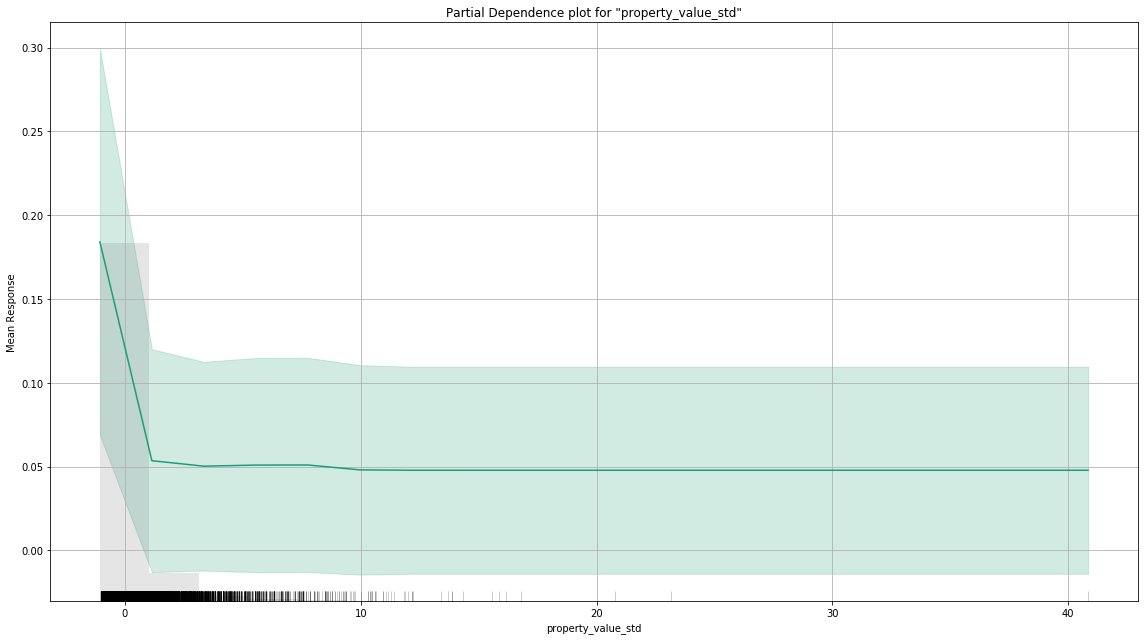

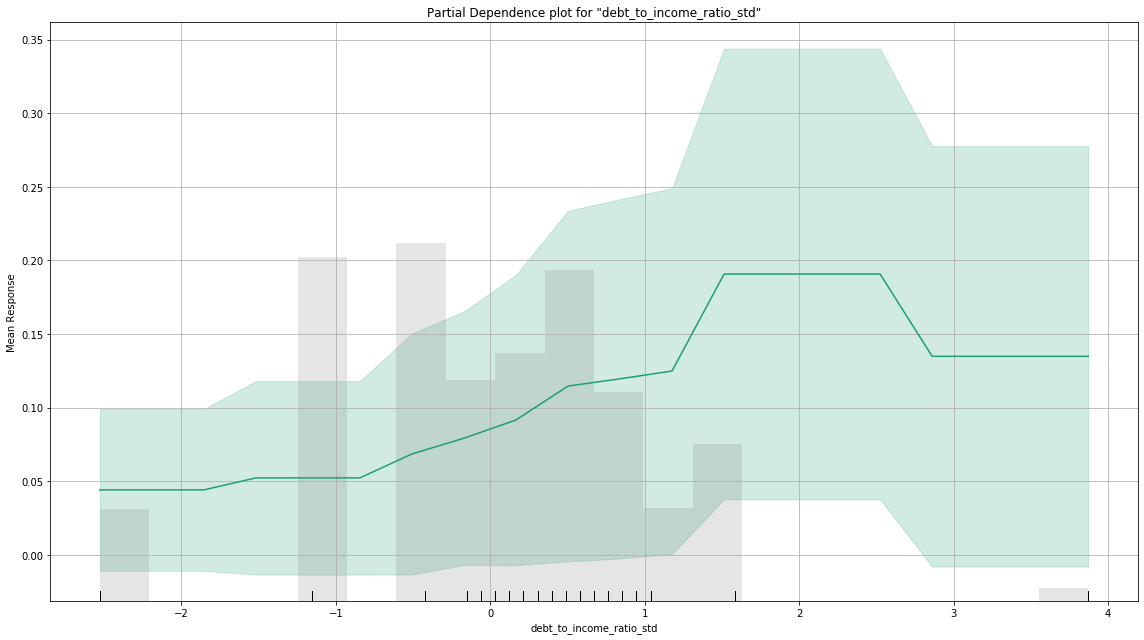

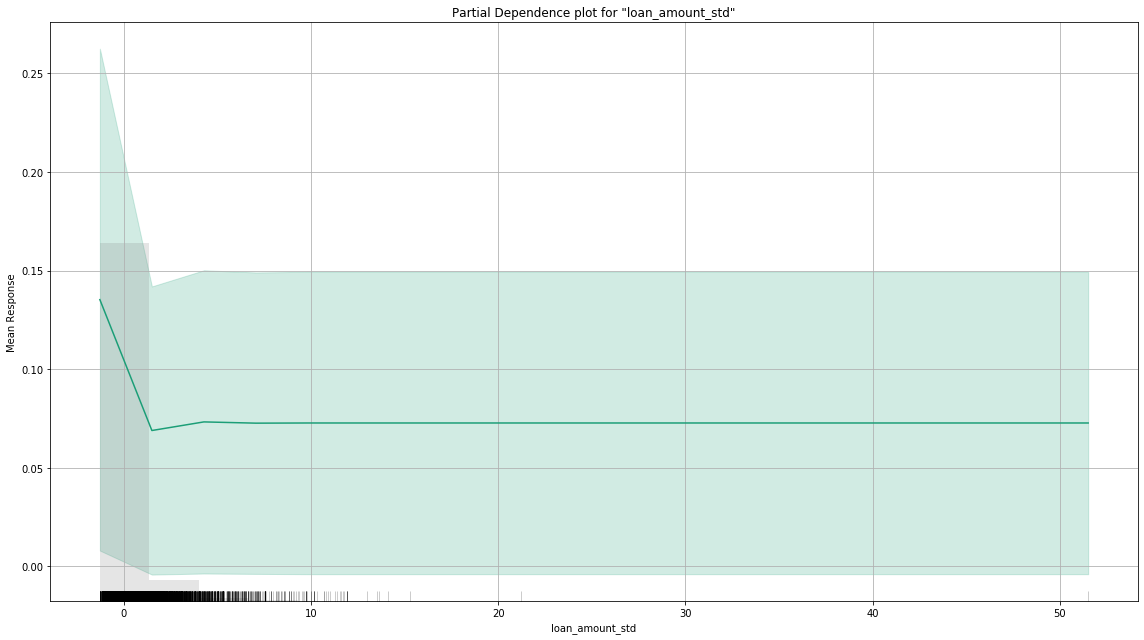

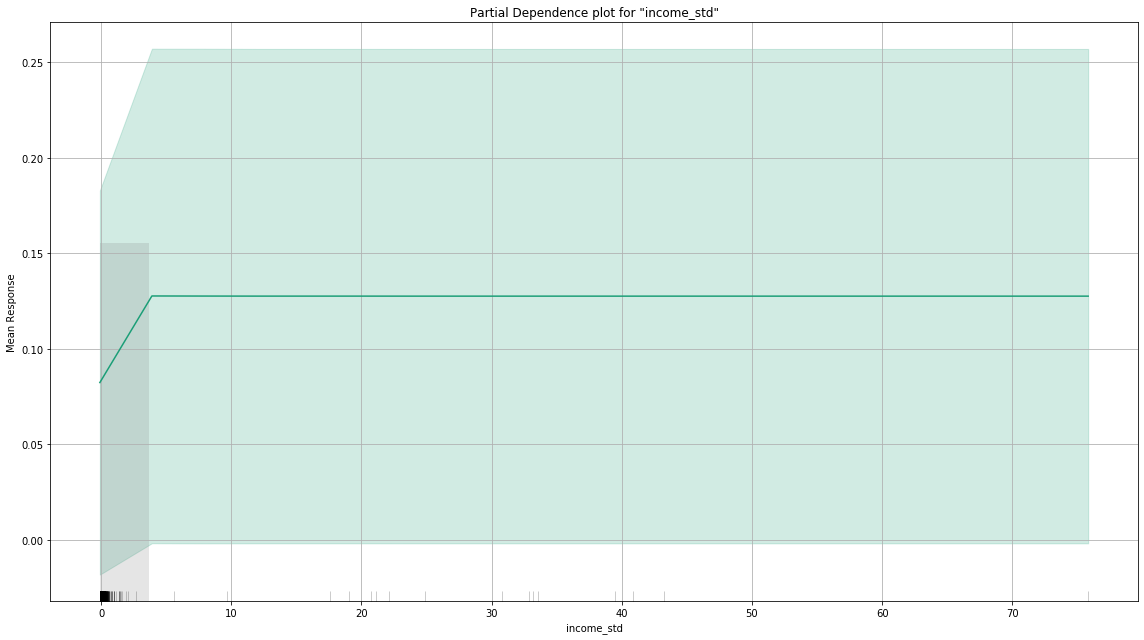

In [335]:
best_gbm_model1.explain(hvalid)

#### Plot Partial Dependence Plots

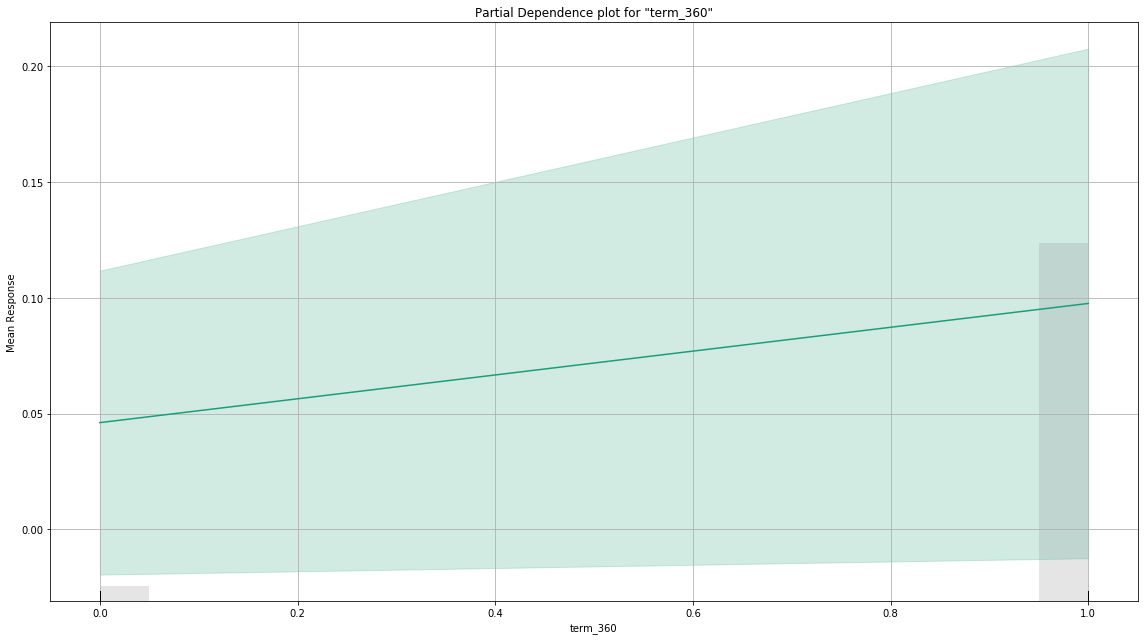

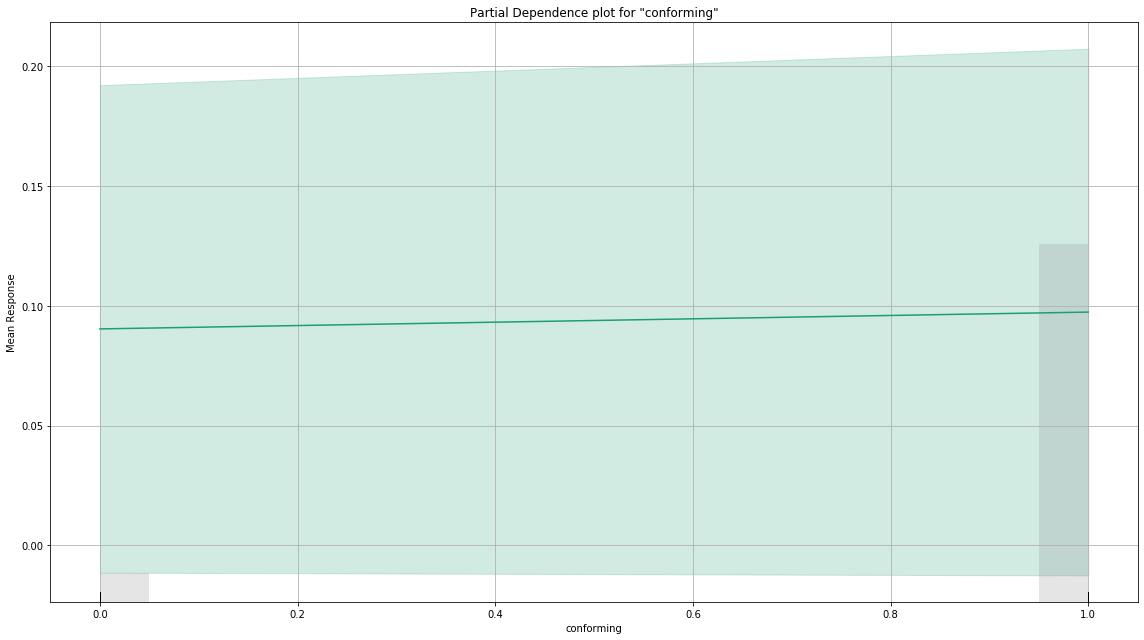

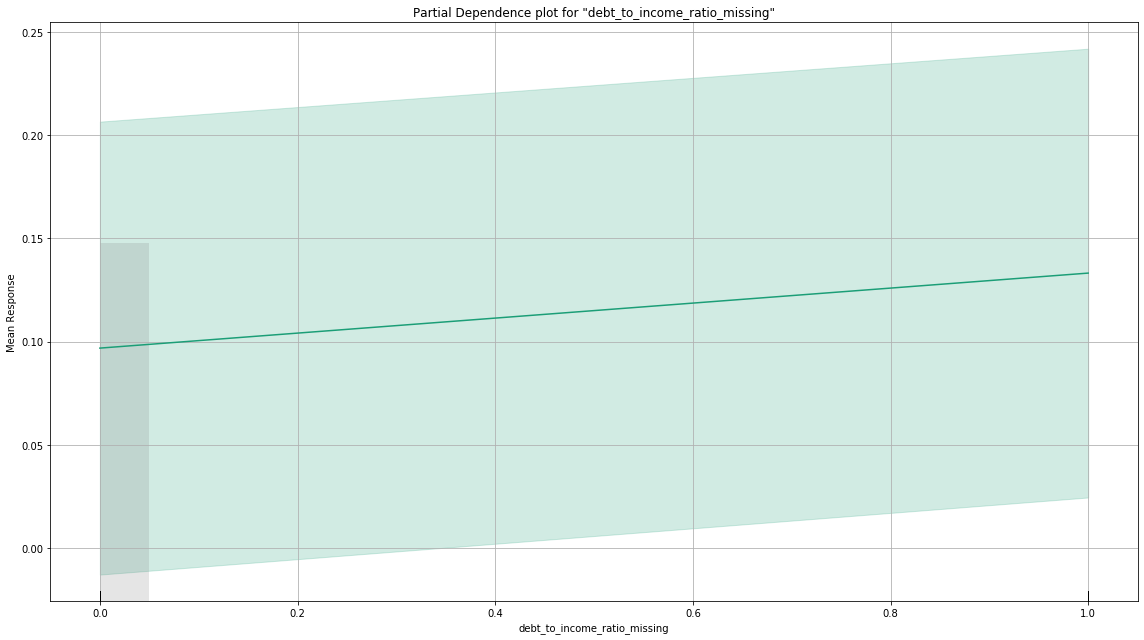

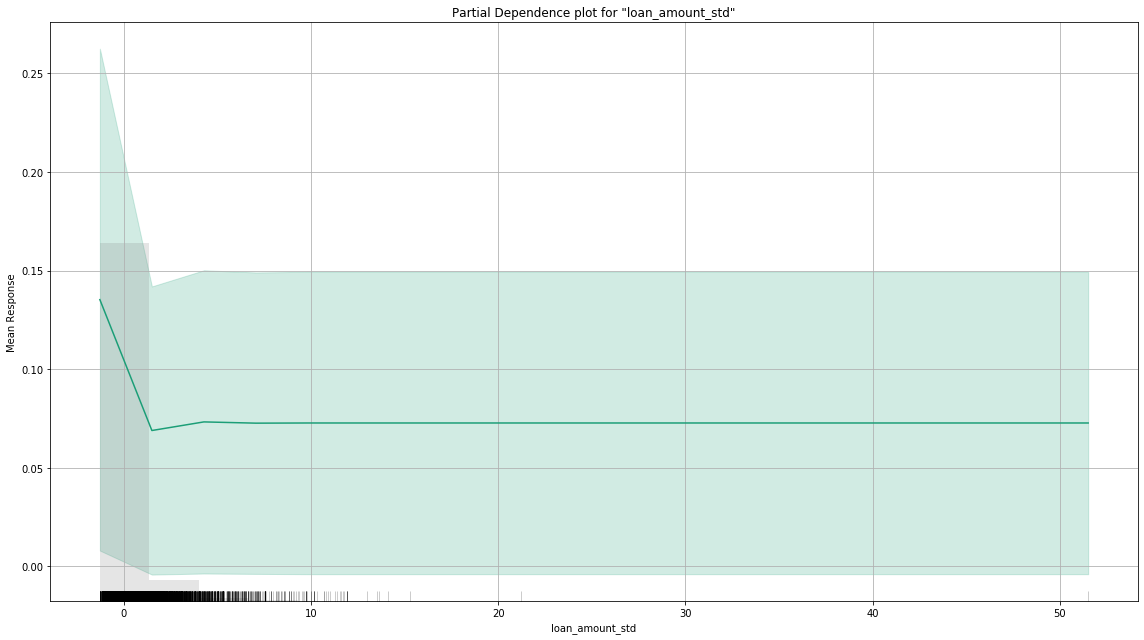

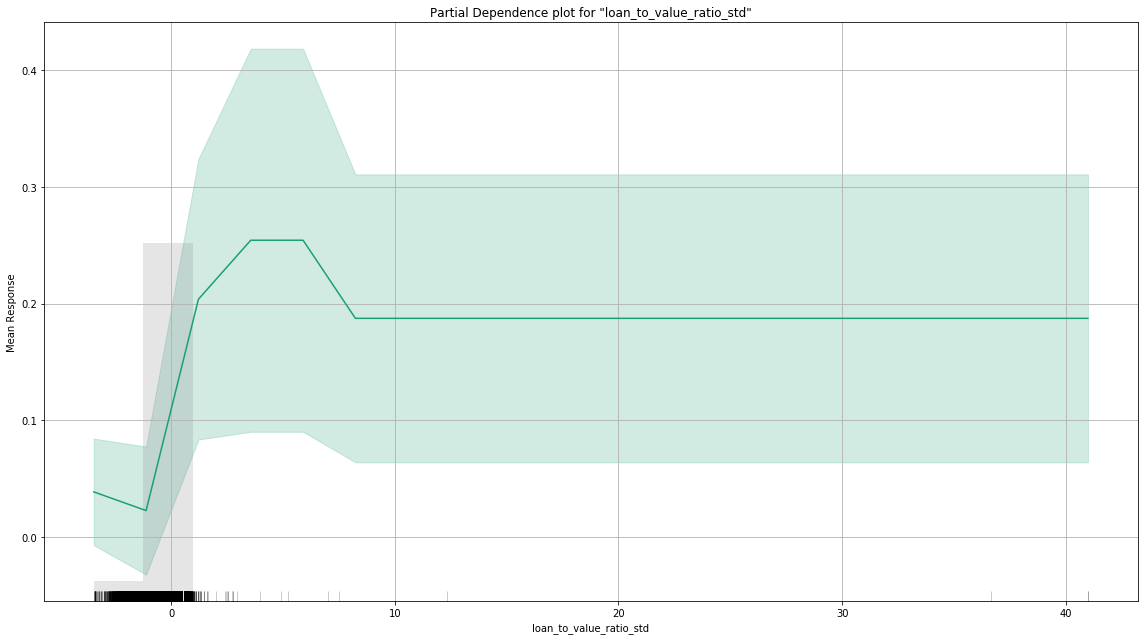

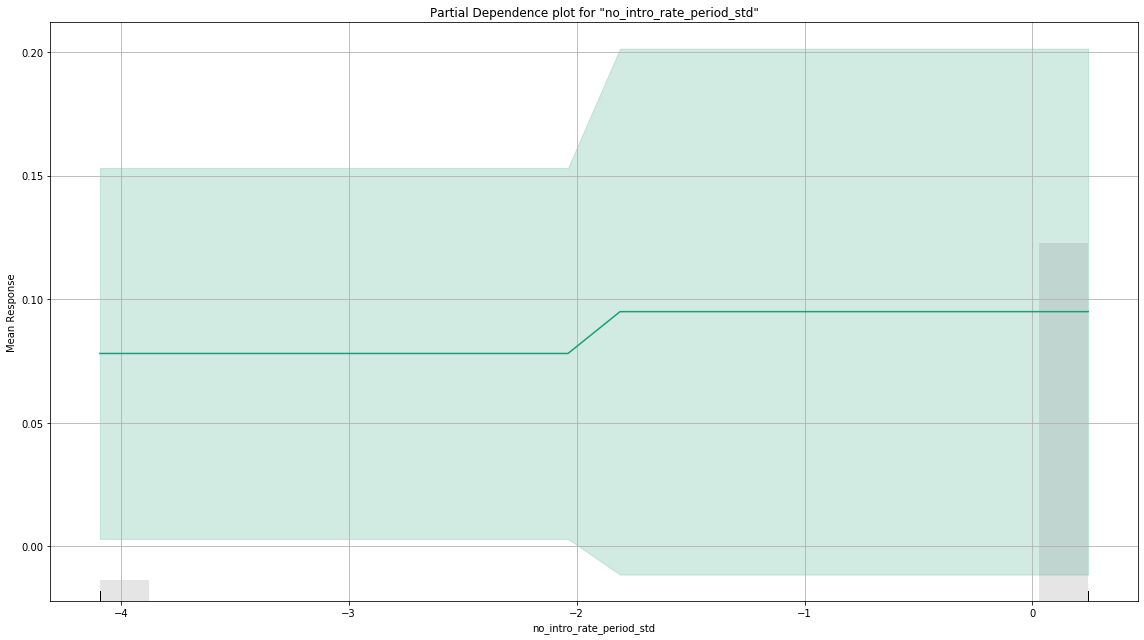

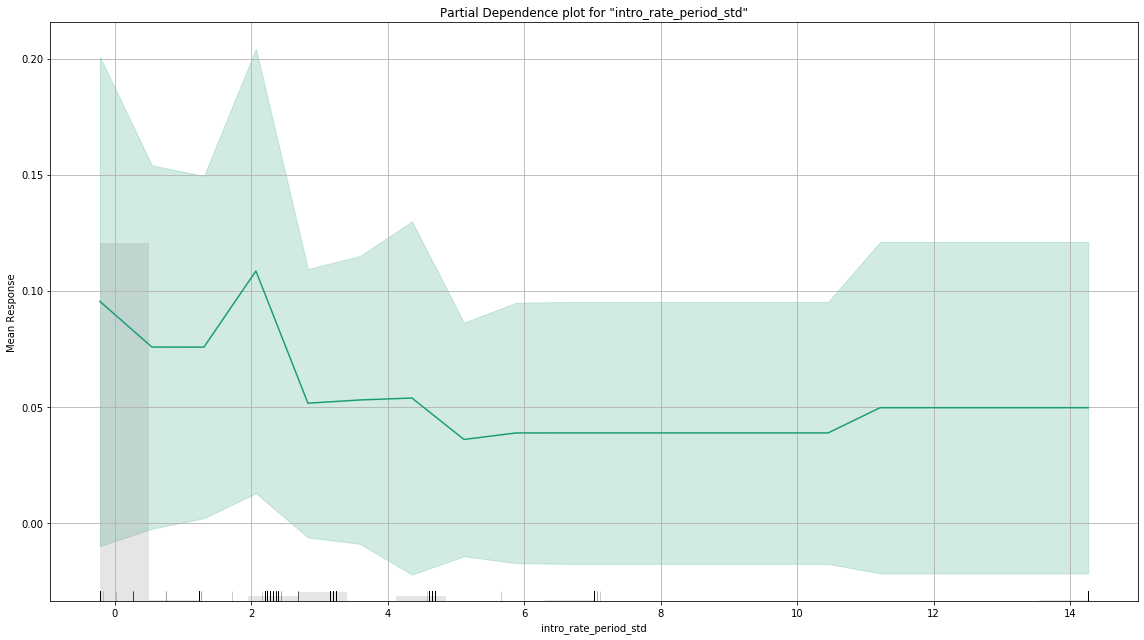

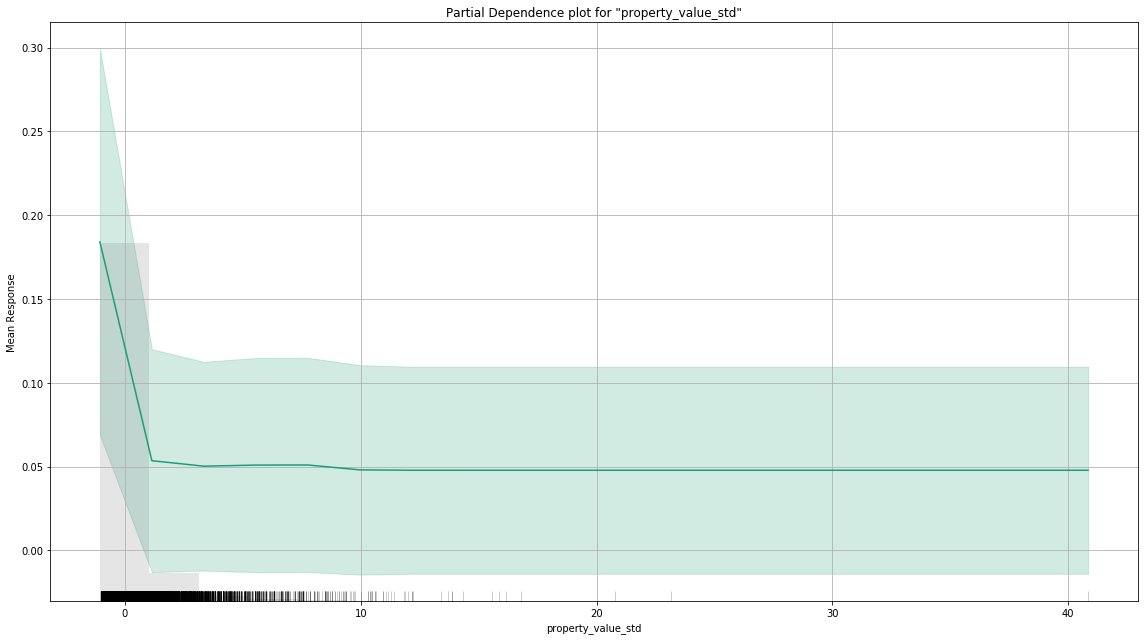

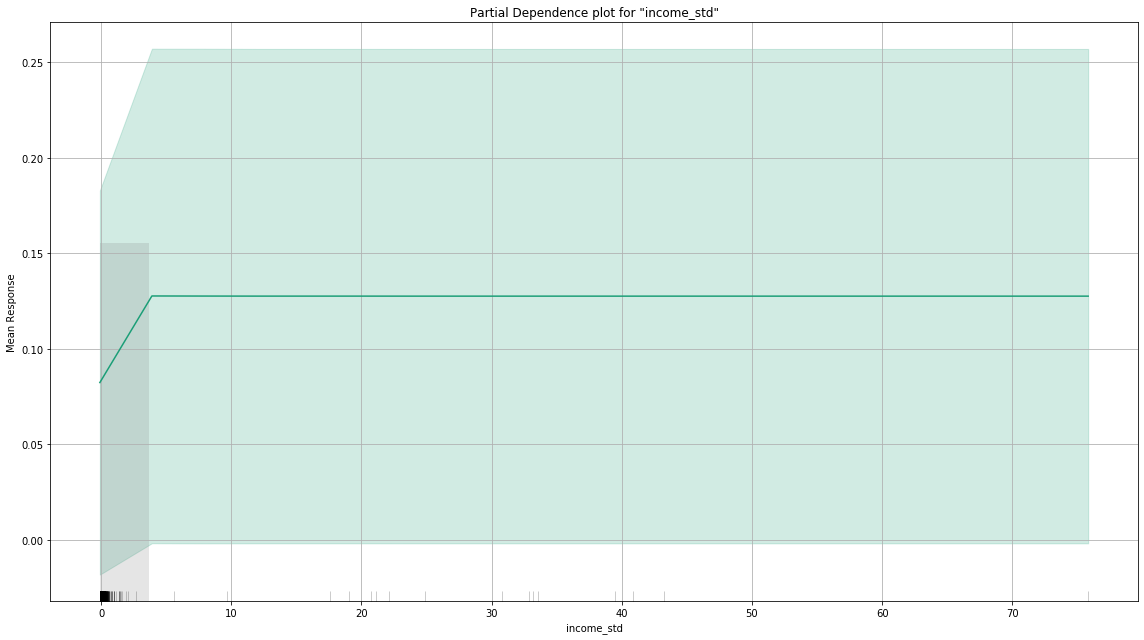

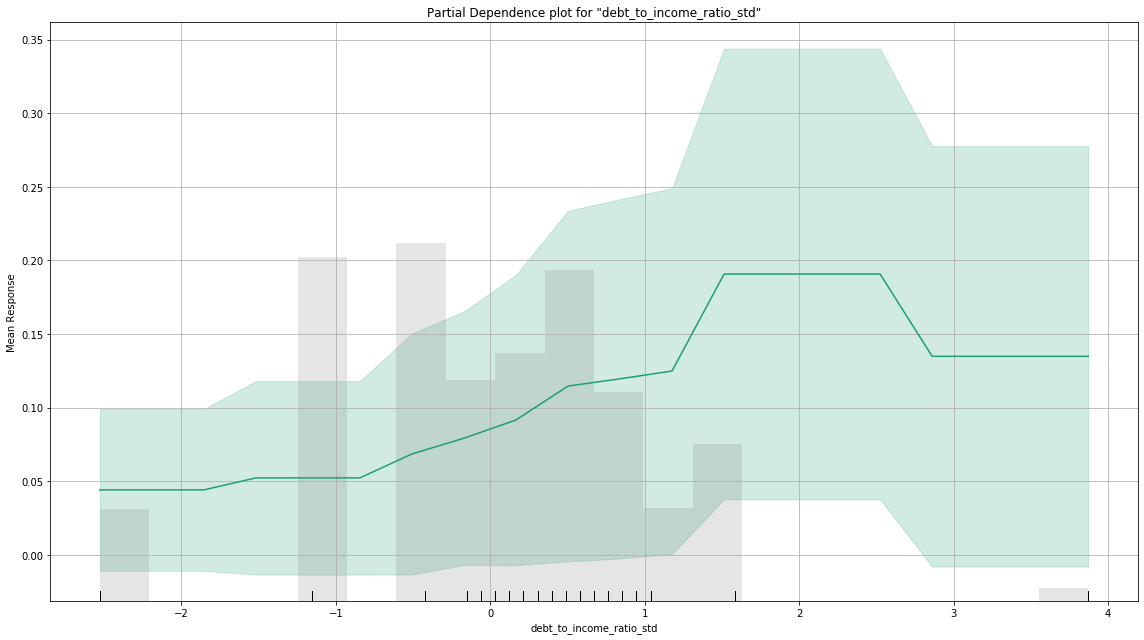

In [344]:
#Plot PD plots for GBM model
for feature in x_names:
    best_gbm_model1.pd_plot(hvalid, column = feature)

#### Plot ICE Plots

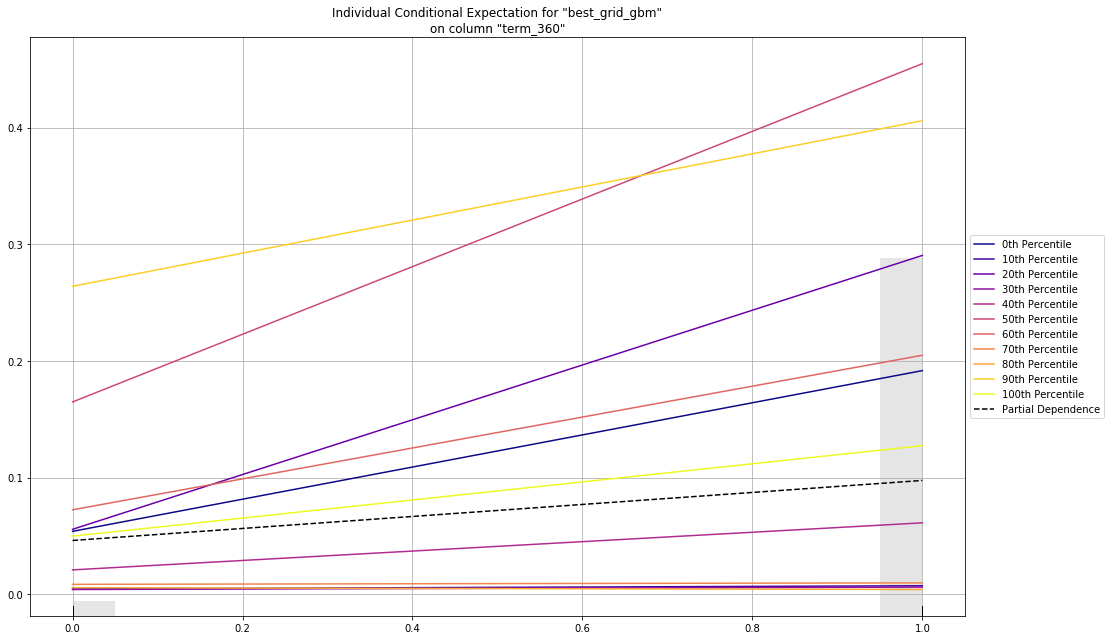

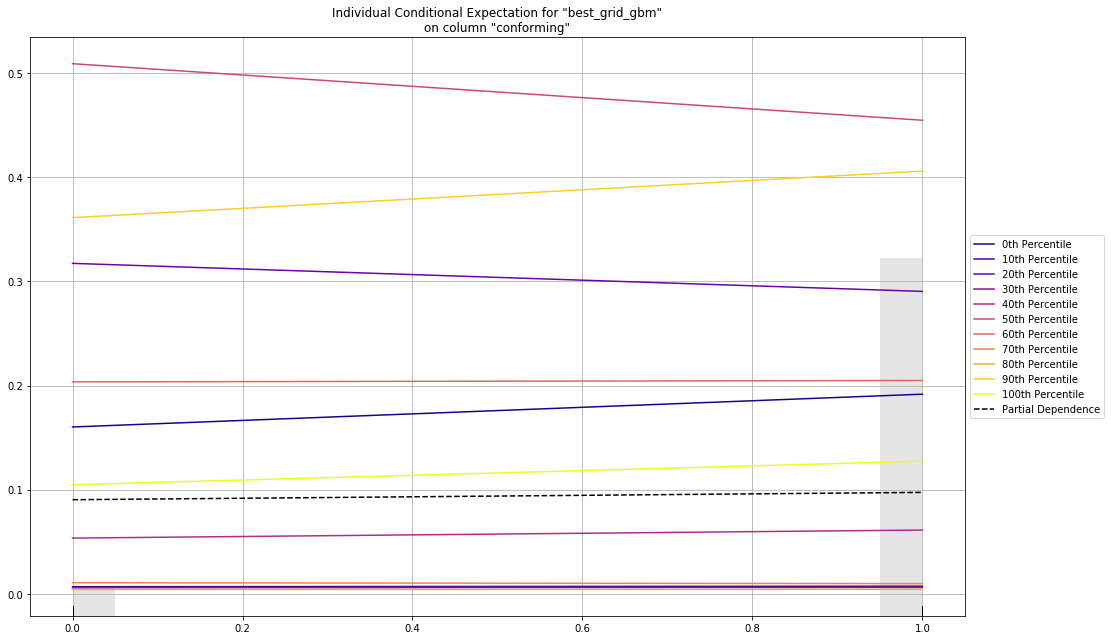

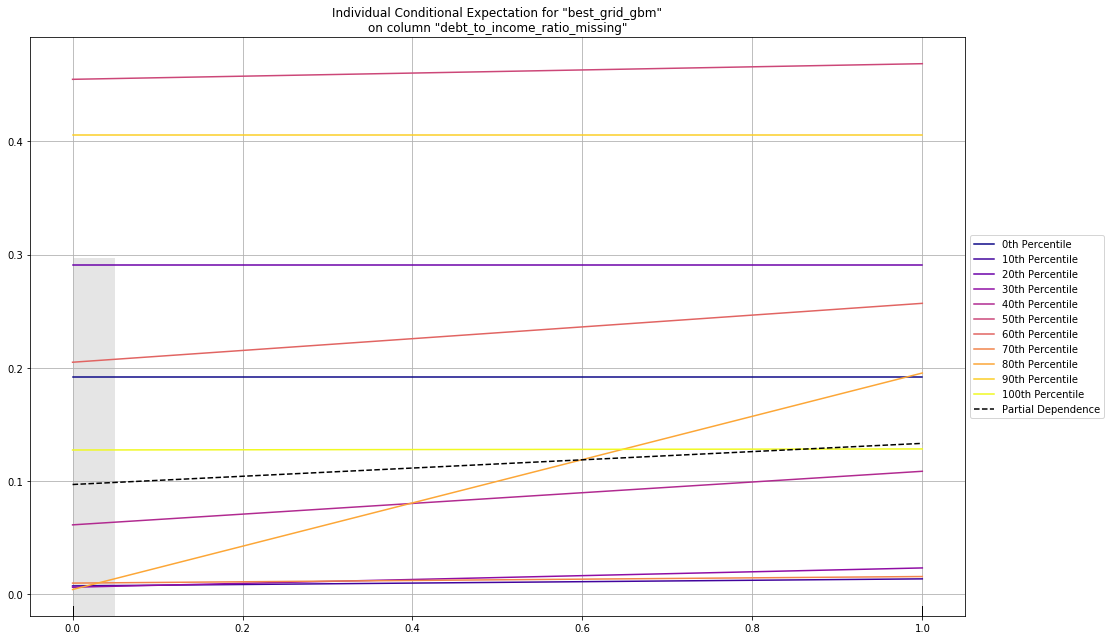

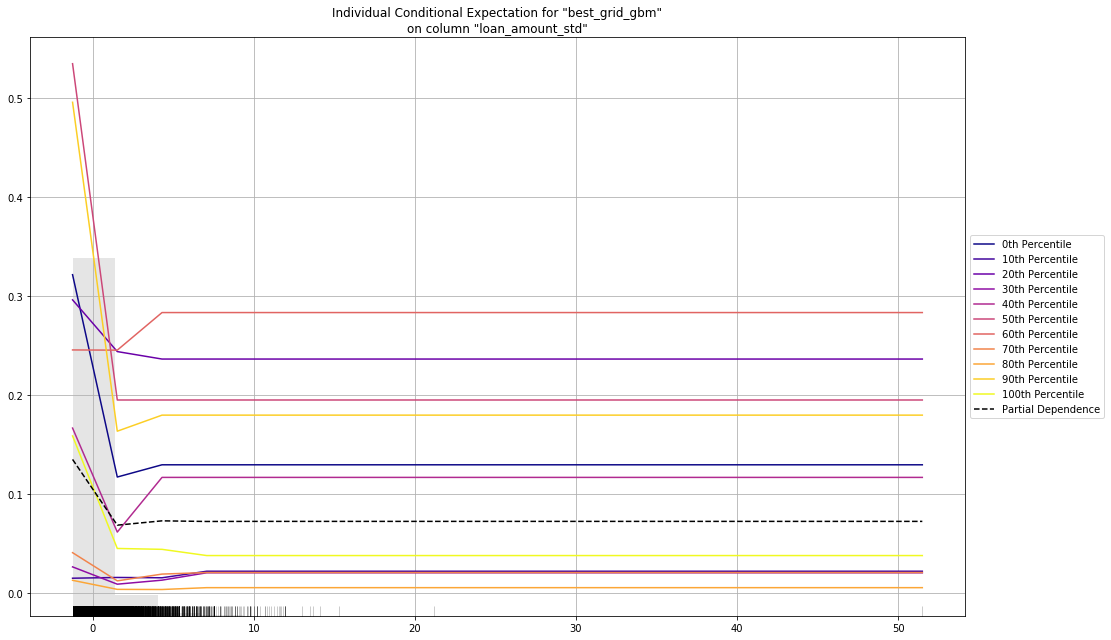

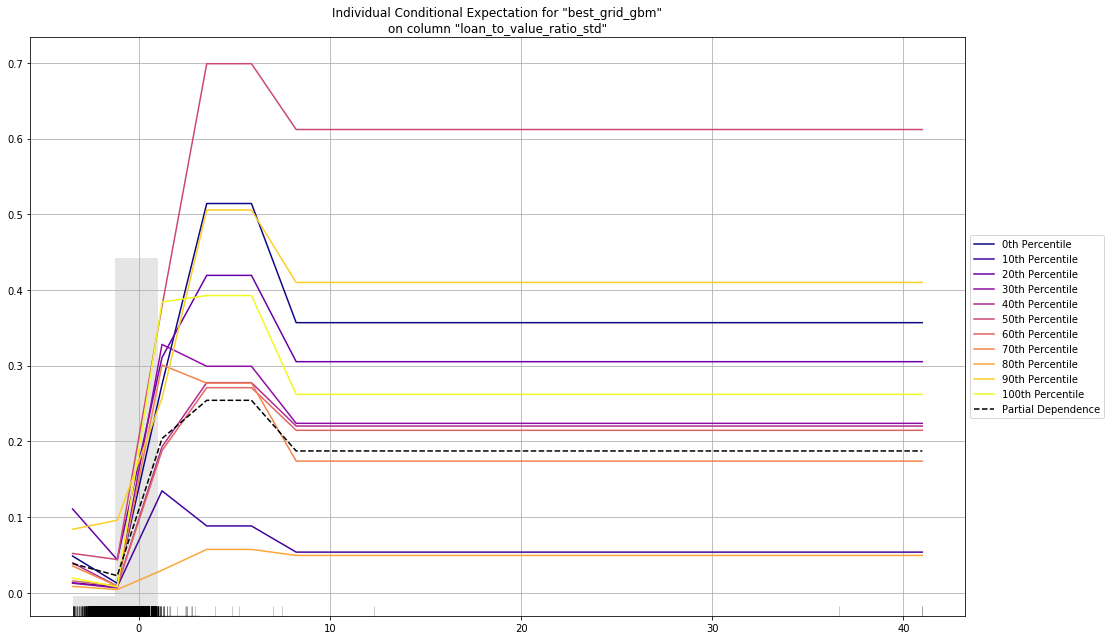

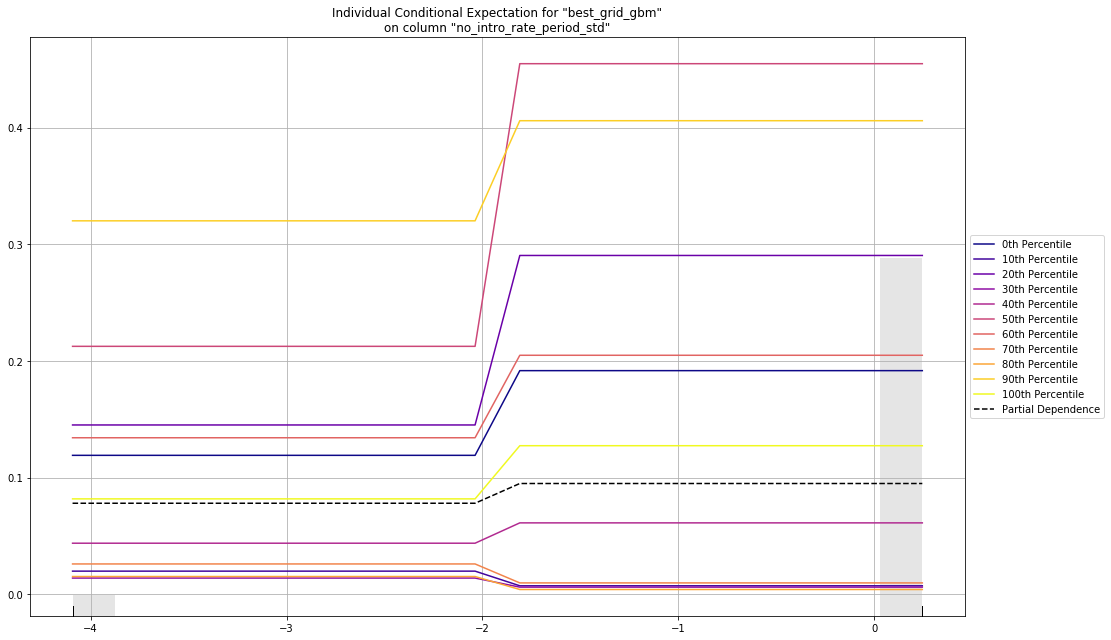

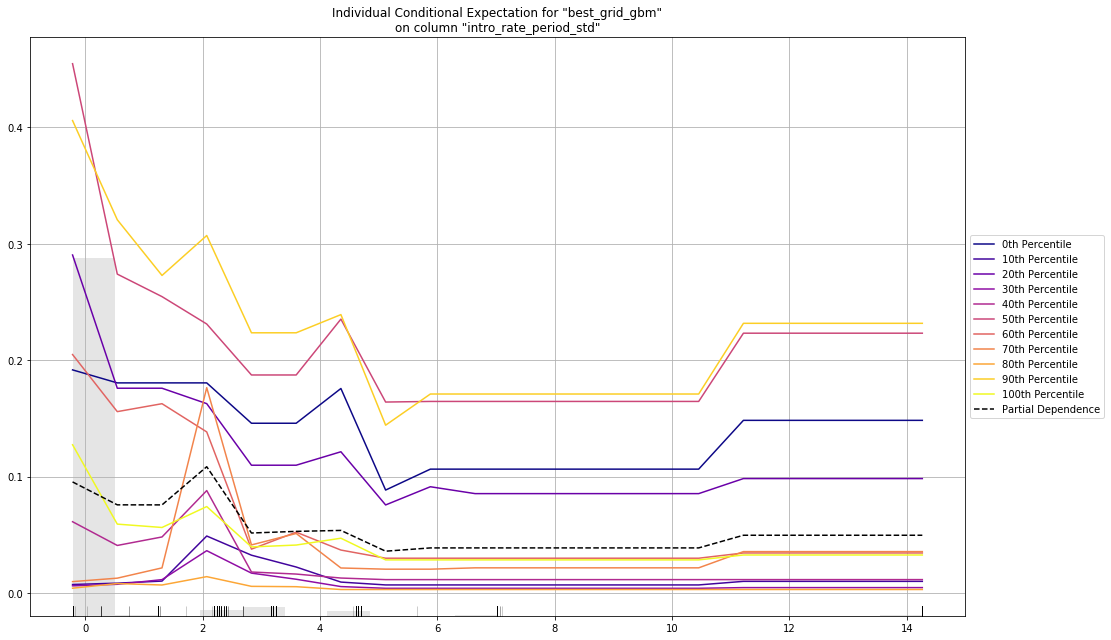

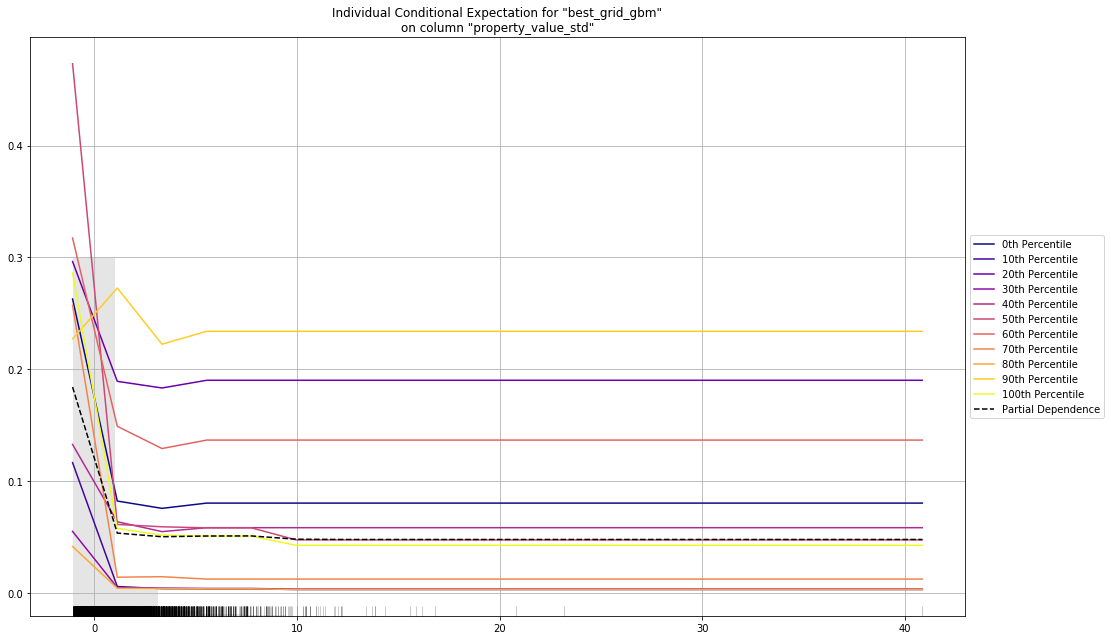

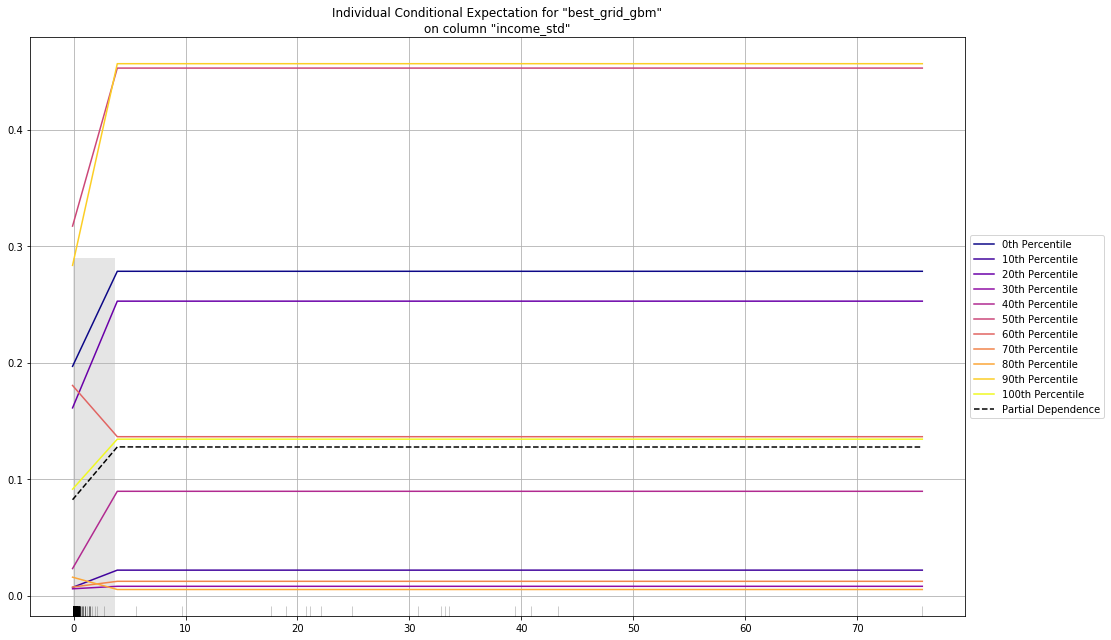

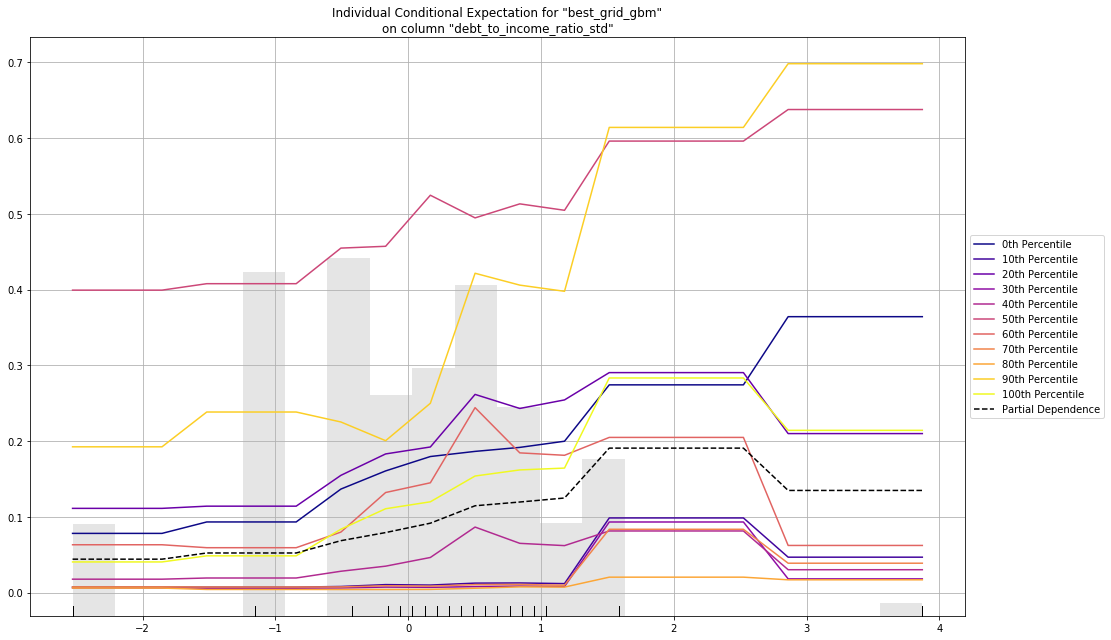

In [343]:
#Plot ICE plots for GBM model
for feature in x_names:
    best_gbm_model1.ice_plot(hvalid, column = feature)

loan_to_value_ratio_std and debt_to_income_std appear to have the steepest partial dependence and ICE curves suggesting the modelis sensitive to changes in these variables. This doesn't come as a surprise since these were the most important features in our GBM model.

#### End timer

In [263]:
global_toc = time.time() - global_tic
print('All tasks completed in %.2f s.' % (global_toc))

All tasks completed in 99253.69 s.


#### Save models to current directory

In [281]:
best_glm.model_id = 'best_glm'
mono_gbm.model_id = "best_mono_gbm"
best_gbm_model1.model_id = "best_grid_gbm"
h2o.save_model(best_glm, force=True)
h2o.save_model(mono_gbm, force = True)
h2o.save_model(best_gbm_model1, force = True)

'/Users/adelhassen/DNSC 6290 ML/best_grid_gbm'

#### Shutdown h2o

In [ ]:
h2o.cluster().shutdown(prompt=False)